In [34]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [61]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [37]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [38]:
from solver import deasolver

In [39]:
results = []
df_imp = pd.DataFrame()

In [40]:
path = "Data/RealData/Recurcive/"

In [41]:
df = pd.read_excel(path + 'egrid2020_data.xlsx', index_col=0)
df

Input_Number of generators  Input_Plant nameplate capacity (MW)  \
DMU 0001                           4                                  1.5   
DMU 0002                           8                                121.4   
DMU 0003                           4                                  1.9   
DMU 0004                           6                                  2.6   
DMU 0005                           3                                 36.2   
...                              ...                                  ...   
DMU 1729                           3                                 22.5   
DMU 1730                           1                                  2.7   
DMU 1731                           1                                 40.0   
DMU 1732                           2                                  2.0   
DMU 1733                           8                                  8.4   

          Input_Plant total annual heat input (MMBtu)  \
DMU 0001                                    11554.999   
DMU 0002                                   115024.996   
DMU 0003                                    16506.999   
DMU 0004                                    26541.000   
DMU 0005                                     5298.000   
...                                               ...   
DMU 1729                                    11058.999   
DMU 1730                                     1335.000   
DMU 1731                                   168852.656   
DMU 1732                                     1299.000   
DMU 1733                                    68567.022   

          Input_Plant annual NOx emissions (tons)  \
DMU 0001                                 1212.000   
DMU 0002                                 7646.000   
DMU 0003                                 1641.999   
DMU 0004                                 2183.001   
DMU 0005                                 -143.000   
...                                           ...   
DMU 1729                                  615.999   
DMU 1730                                  100.000   
DMU 1731                                15983.000   
DMU 1732                                   85.000   
DMU 1733                                11814.570   

          Input_Plant annual SO2 emissions (tons)  \
DMU 0001                                   19.200   
DMU 0002                                   18.056   
DMU 0003                                   26.523   
DMU 0004                                   44.968   
DMU 0005                                    3.051   
...                                           ...   
DMU 1729                                    1.842   
DMU 1730                                    2.134   
DMU 1731                                    4.926   
DMU 1732                                    2.078   
DMU 1733                                    9.274   

          Input_Plant annual CO2 emissions (tons)  \
DMU 0001                                    1.675   
DMU 0002                                    0.193   
DMU 0003                                    2.393   
DMU 0004                                    3.848   
DMU 0005                                    1.279   
...                                           ...   
DMU 1729                                    0.018   
DMU 1730                                    0.194   
DMU 1731                                    0.100   
DMU 1732                                    0.188   
DMU 1733                                    0.035   

          Input_Plant annual CH4 emissions (lbs)  \
DMU 0001                                 943.616   
DMU 0002                                6724.603   
DMU 0003                                1348.008   
DMU 0004                                2167.415   
DMU 0005                                 432.650   
...                                          ...   
DMU 1729                                 646.338   
DMU 1730                                 109.020   
DMU 1731             

In [42]:
df.shape

(1733, 9)

In [97]:
def ml(df, sol_filepath="Data/RealData/Recurcive/egrid2020_data_Sol_0.xlsx", sheetname = 0, i=0):
    
    df_sol = pd.read_excel(sol_filepath, sheet_name = sheetname, index_col = 0)[['Efficiency_Scores']]
    df_weights = pd.read_excel(sol_filepath, sheet_name = sheetname, index_col = 0).iloc[:, 1:]
    
    df_zero = (df_weights==0).sum()
    print("df_zero: \n", df_zero)
    
    total_zeros = (df_weights==0).sum().sum()
    print("Total Zeros: ", total_zeros)
    
    X = df
    y = df_sol
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    gb_model = GradientBoostingRegressor(random_state=42)

    pipe_gb = make_pipeline(std_scaler, gb_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())
    
    learning_rate = [1, 0.5, 0.1,  0.01]
    n_estimators = [50, 100, 200, 500, 1000, 2000]
    max_depth = [3, 5, 10, None]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 20, 30]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    subsample = [0.3, 0.5, 0.75, 1.0]
    
    # specify parameter values to search
    params = {}
    params['gradientboostingregressor__learning_rate'] = learning_rate
    params['gradientboostingregressor__n_estimators'] = n_estimators
    params['gradientboostingregressor__max_depth'] = max_depth
    params['gradientboostingregressor__min_samples_split'] = min_samples_split
    params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
    params['gradientboostingregressor__subsample'] = subsample
    
    grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
    grid.fit(X, y.values.ravel())
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())
    
    imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
    df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
    input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (i,
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               "total_zeros": total_zeros},
              )
    
    df_zero.index = [f.split('_',1)[1] for f in df_zero.index]
    
    df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on='Feature Name', right_on='index')
    
    df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
    
    df_merged["Iteration"] = i
    
    return pipe_gb, results, y, df_merged

In [98]:
sheets = pd.ExcelFile(path + 'egrid2020_data.xlsx').sheet_names
sheets

['Sheet1']

In [100]:
for sheet in sheets:

    print("*"*50 , "SHEET: " , sheet, "*"*50)
    
    # os.mkdir(path + f"Output/{sheet}" )
    
    df = pd.read_excel(path + 'egrid2020_data.xlsx', sheet_name=sheet, index_col = 0)
    
    print(df.head(2))
    results = []
    df_imp = pd.DataFrame()
    
    for i in range(20):
        
        print("*"*20, "İ:", i, "*"*20)

        if i == 0:
            deasolver(inputfile = path + 'egrid2020_data.xlsx', read_sheetname = sheet, folder = path + f"Output/{sheet}/", out_suffix1 = f"_Sol")
            #pipe_gb, r, y, df_merged = ml(df=df, sol_filepath=f"Data/Data100/Output/{sheet}" + "/US12I1O_Sol_" + str(i) + ".xlsx", i=i)
        else:
            deasolver(inputfile = path + 'egrid2020_data.xlsx', read_sheetname = sheet, existing_excel_file = path + f"Output/{sheet}/egrid2020_data_Sol.xlsx", write_sheetname = f"Sheet_{i}", folder = f"Data/Data100/Output/{sheet}/", out_suffix1 = f"_Sol", input_imp = r)
        pipe_gb, r, y, df_merged = ml(df=df, sol_filepath = path + f"Output/{sheet}/egrid2020_data_Sol.xlsx", sheetname= i, i=i)

        #pipe_gb, r, y, df_merged = ml(df=df, sol_filepath=f"Data/Data100/US12I1O_Sol_{i}.xlsx", i=i)
        results.append(r)

        df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
        
        

        print("RESULTS: ", results)

        if i != 0:
            if results[-1][2] == results[-2][2]:
                print("*"*10 + "BREAK" + "*"*10)
                break

    with open(path + f'Results/GB_result_12I1O_{sheet}.pkl', 'wb') as f:
        pickle.dump(results, f)

    df_imp.to_pickle(path + f'Results/GB_12I1O_df_imp_{sheet}.pkl')

************************************************** SHEET:  Sheet1 **************************************************
          Input_Number of generators  Input_Plant nameplate capacity (MW)  \
DMU 0001                           4                                  1.5   
DMU 0002                           8                                121.4   

          Input_Plant total annual heat input (MMBtu)  \
DMU 0001                                    11554.999   
DMU 0002                                   115024.996   

          Input_Plant annual NOx emissions (tons)  \
DMU 0001                                   1212.0   
DMU 0002                                   7646.0   

          Input_Plant annual SO2 emissions (tons)  \
DMU 0001                                   19.200   
DMU 0002                                   18.056   

          Input_Plant annual CO2 emissions (tons)  \
DMU 0001                                    1.675   
DMU 0002                                    0.193   


In [43]:
def ml(df=df, sol_filepath="Data/RealData/Recurcive/egrid2020_data_Sol_0.xlsx", i=None):
    
    df_sol = pd.read_excel(sol_filepath, index_col = 0)[['Efficiency_Scores']]
    df_weights = pd.read_excel(sol_filepath, index_col = 0).iloc[:, 1:]
    
    df_zero = (df_weights==0).sum()
    print("df_zero: \n", df_zero)
    
    total_zeros = (df_weights==0).sum().sum()
    print("Total Zeros: ", total_zeros)
    
    plt.figure(figsize=(18,12))
    sns.heatmap(df_weights.eq(0).transpose(),
            cmap="YlGnBu",
            cbar=False,
            cbar_kws={'label': 'Zero Values'});
    
    X = df
    y = df_sol
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    gb_model = GradientBoostingRegressor(random_state=42)

    pipe_gb = make_pipeline(std_scaler, gb_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())
    
    learning_rate = [1, 0.5, 0.1,  0.01]
    n_estimators = [50, 100, 200, 500, 1000, 2000]
    max_depth = [3, 5, 10, None]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 20, 30]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    subsample = [0.3, 0.5, 0.75, 1.0]
    
    # specify parameter values to search
    params = {}
    params['gradientboostingregressor__learning_rate'] = learning_rate
    params['gradientboostingregressor__n_estimators'] = n_estimators
    params['gradientboostingregressor__max_depth'] = max_depth
    params['gradientboostingregressor__min_samples_split'] = min_samples_split
    params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
    params['gradientboostingregressor__subsample'] = subsample
    
    grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
    grid.fit(X, y.values.ravel())
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())
    
    imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
    df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
    input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (i,
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               "total_zeros": total_zeros},
              )
    
    fig = px.bar(df_gb, x="Importance", y="Feature Name")

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"GradientBoostingRegressor Feature Importances",
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show()
    
    df_zero.index = [f.split('_')[1] for f in df_zero.index]
    
    df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on='Feature Name', right_on='index')
    df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
    
    df_merged["Iteration"] = i
    
    fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
    )

    fig.show()
    
    return pipe_gb, results, y, df_merged

In [44]:
def plotScatter(res_gb, x, y, colorCol, blueCount, redCount):

    fig = px.scatter(res_gb, x=x, y=y, color = colorCol, color_discrete_map= {True:"blue", False: "red"},
                     hover_data=[x, y, colorCol] + [res_gb.index])


    fig.add_traces(
        list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
    )

    fig.update_traces(line_color='lightgreen', line_width=3)

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"Efficiency Scores Comparison (Blue: {blueCount}, Red: {redCount})",
    )

    fig.show()

In [45]:
def compareML(pipe_gb, y, X=df, err_thresh = 3):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = pipe_gb.fit(X_train, y_train.values.ravel())
    prediction = model.predict(X_test)
    
    res = pd.DataFrame()
    res["Prediction"] = pd.Series(prediction.ravel())
    res["Actual"] = y_test.values
    res["Diff"] = res.Prediction - res.Actual
    res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
    res[f"Error_Perc < {err_thresh}"] = np.abs(res["Error_Perc"]) < err_thresh  
    res = res.round(4)
    print("res: ", res)
    
    blue = res[f"Error_Perc < {err_thresh}"].sum()
    print("blue: ", blue)
    red = len(res[f"Error_Perc < {err_thresh}"]) - (res[f"Error_Perc < {err_thresh}"].sum())
    print("red: ", red)
    
    rho, p = stats.spearmanr(res.Prediction, res.Actual)
    print("rho:", rho.round(4)) 
    print("p-Value", p.round(4)) 
    
    plotScatter(res, x="Actual", y="Prediction", colorCol=f"Error_Perc < {err_thresh}",
               blueCount=blue, redCount=red)

In [46]:
def compareES(df_1_path=None, df_0_path=None, df_basic_path="Data/RealData/Recurcive/egrid2020_data_Sol_0.xlsx", err_thresh = 10):
    
    df_basic = pd.read_excel(df_basic_path, index_col=0)
    df_1 = pd.read_excel(df_1_path, index_col=0)
    
    res_gb = pd.DataFrame()
    res_gb["Efficiency_Scores_Basic"] = df_basic["Efficiency_Scores"]
    res_gb["Efficiency_Scores_ML"] = df_1["Efficiency_Scores"]

    
    res_gb["Diff_Basic"] = res_gb["Efficiency_Scores_Basic"]  - res_gb["Efficiency_Scores_ML"]
    res_gb["Diff_Basic_Perc"] = (res_gb["Diff_Basic"] / res_gb["Efficiency_Scores_Basic"]) * 100 
    res_gb[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_gb["Diff_Basic_Perc"]) < err_thresh
    
    res_gb["Diff_Basic"] = res_gb["Efficiency_Scores_Basic"]  - res_gb["Efficiency_Scores_ML"]
    res_gb["Diff_Basic_Perc"] = (res_gb["Diff_Basic"] / res_gb["Efficiency_Scores_Basic"]) * 100 
    res_gb[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_gb["Diff_Basic_Perc"]) < err_thresh
    
    blue = res_gb[f"Diff_Basic_Perc < {err_thresh}"].sum()
    print("blue : ", blue)
    red = len(res_gb[f"Diff_Basic_Perc < {err_thresh}"]) - (res_gb[f"Diff_Basic_Perc < {err_thresh}"].sum())
    print("red : ", red)
    
    res_gb = res_gb.round(4)
    
    plotScatter(res_gb, x="Efficiency_Scores_Basic", y="Efficiency_Scores_ML", colorCol=f"Diff_Basic_Perc < {err_thresh}",
               blueCount=blue, redCount=red)
       
    if df_0_path:
        
        df_0 = pd.read_excel(df_0_path, index_col=0)
        res_gb["Efficiency_Scores_ML_Pr"] = df_0["Efficiency_Scores"]
        
        res_gb["Diff_Previous"] = res_gb["Efficiency_Scores_ML_Pr"]  - res_gb["Efficiency_Scores_ML"]
        res_gb["Diff_Previous_Perc"] = (res_gb["Diff_Previous"] / res_gb["Efficiency_Scores_ML_Pr"]) * 100 
        res_gb[f"Diff_Previous_Perc < {err_thresh}"] = np.abs(res_gb["Diff_Previous_Perc"]) < err_thresh
        
        blue = res_gb[f"Diff_Previous_Perc < {err_thresh}"].sum()
        print("blue : ", blue)
        red = len(res_gb[f"Diff_Previous_Perc < {err_thresh}"]) - (res_gb[f"Diff_Previous_Perc < {err_thresh}"].sum())
        print("red : ", red)
        
        #res_gb = res_gb.round(4)
        
        plotScatter(res_gb, x="Efficiency_Scores_ML_Pr", y="Efficiency_Scores_ML", colorCol=f"Diff_Previous_Perc < {err_thresh}",
               blueCount=blue, redCount=red)


In [47]:
i=0

In [48]:
deasolver(inputfile="Data/RealData/Recurcive/egrid2020_data.xlsx", folder = "Data/RealData/Recurcive/", out_suffix1="_Sol_" + str(i))

100.0
Solution file saved outputfile


df_zero: 
 Weight_Input_Number of generators                     1065
Weight_Input_Plant annual CH4 emissions (lbs)         1677
Weight_Input_Plant annual CO2 emissions (tons)         982
Weight_Input_Plant annual N2O emissions (lbs)           16
Weight_Input_Plant annual NOx emissions (tons)         721
Weight_Input_Plant annual SO2 emissions (tons)        1219
Weight_Input_Plant nameplate capacity (MW)            1153
Weight_Input_Plant total annual heat input (MMBtu)    1196
Weight_Output_Plant annual net generation (MWh)          0
dtype: int64
Total Zeros:  8029
neg_mean_squared_error: -0.006195814168500078
neg_root_mean_squared_error: -0.07775279587987372
r2: 0.8127089658082163
grid.best_score:  -0.06212434603981618
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientb

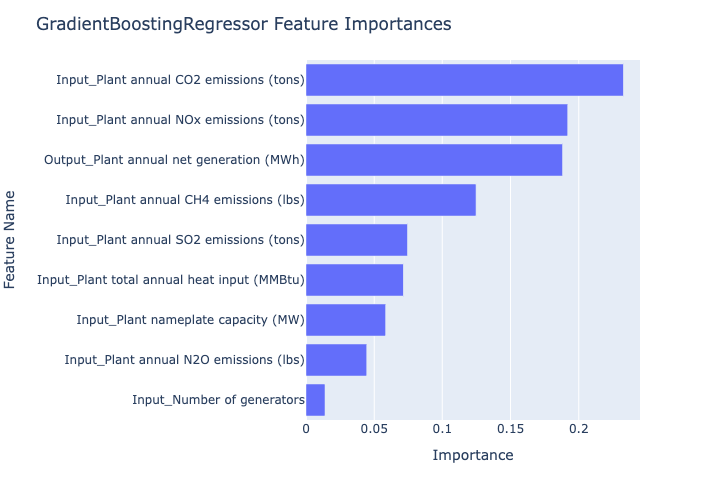

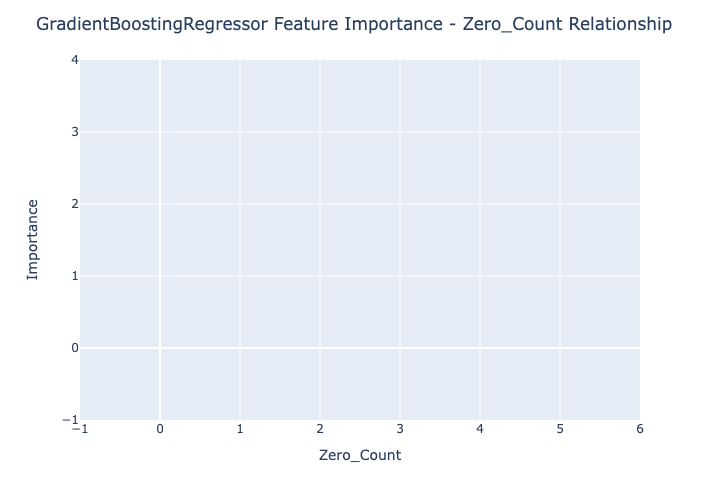

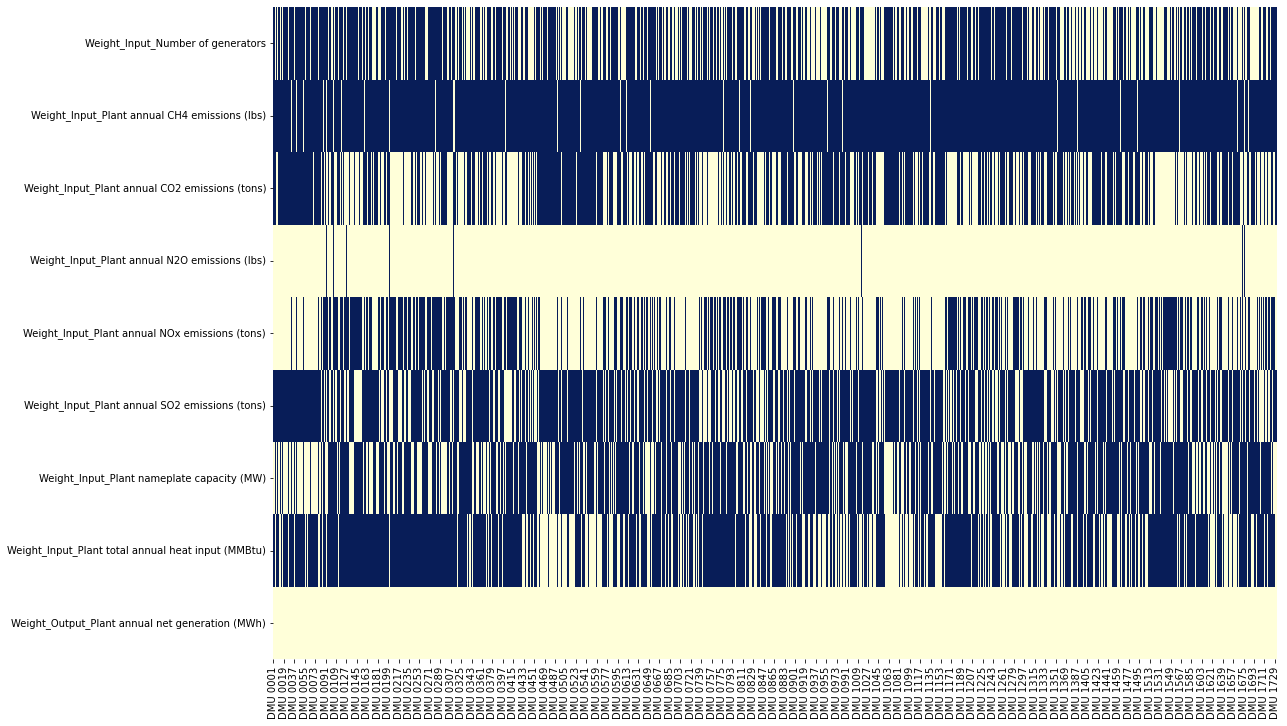

In [49]:
pipe_gb, r, y, df_merged = ml(i=i)
results.append(r)

In [50]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5219  0.5435 -0.0217     -3.9850           False
1        0.4842  0.4909 -0.0067     -1.3651            True
2        0.2169  0.2257 -0.0088     -3.9047           False
3        0.5496  0.5522 -0.0026     -0.4669            True
4        0.3790  0.4459 -0.0669    -15.0036           False
..          ...     ...     ...         ...             ...
342      0.4907  0.5205 -0.0298     -5.7294           False
343      0.2524  0.2733 -0.0209     -7.6642           False
344      0.3826  0.3532  0.0294      8.3381           False
345      0.4627  0.4911 -0.0283     -5.7714           False
346      0.4474  0.4509 -0.0036     -0.7958            True

[347 rows x 5 columns]
blue:  88
red:  259
rho: 0.945
p-Value 0.0


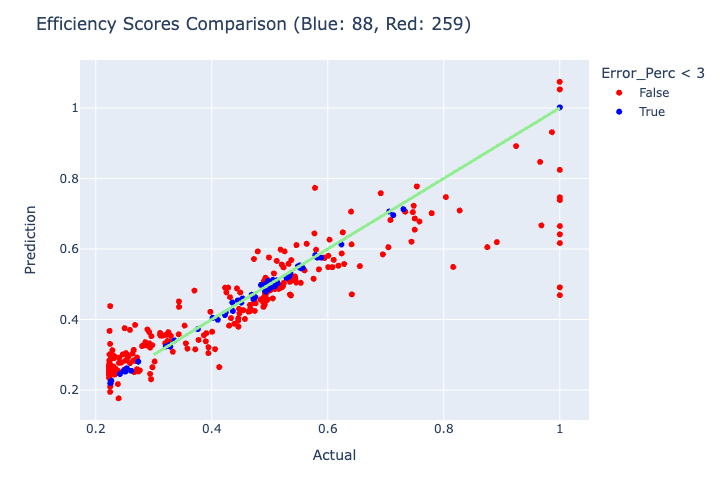

In [51]:
compareML(pipe_gb, y)

### i = 1

In [57]:
i +=1

In [17]:
for r in results[-1:]:
    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01      73
Weight_Input 02       0
Weight_Input 03       0
Weight_Input 04     119
Weight_Input 05     145
Weight_Input 06      15
Weight_Input 07     523
Weight_Input 08      35
Weight_Input 09     349
Weight_Input 10     633
Weight_Input 11       1
Weight_Input 12     302
Weight_Output 01      0
dtype: int64
Total Zeros:  2195
neg_mean_squared_error: -0.0009757084190693242
neg_root_mean_squared_error: -0.031037753014830798
r2: 0.950925094099919
grid.best_score:  -0.023874609653150608
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

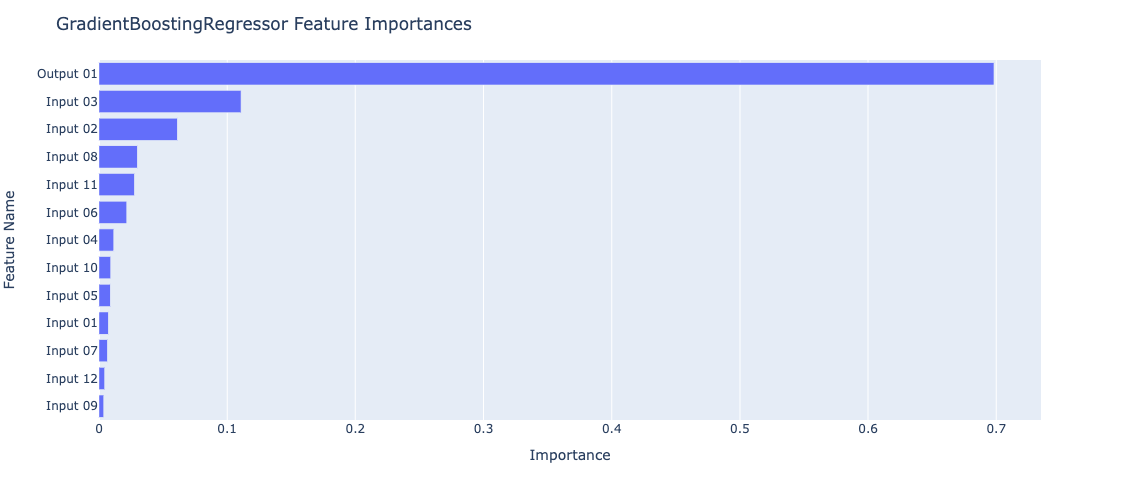

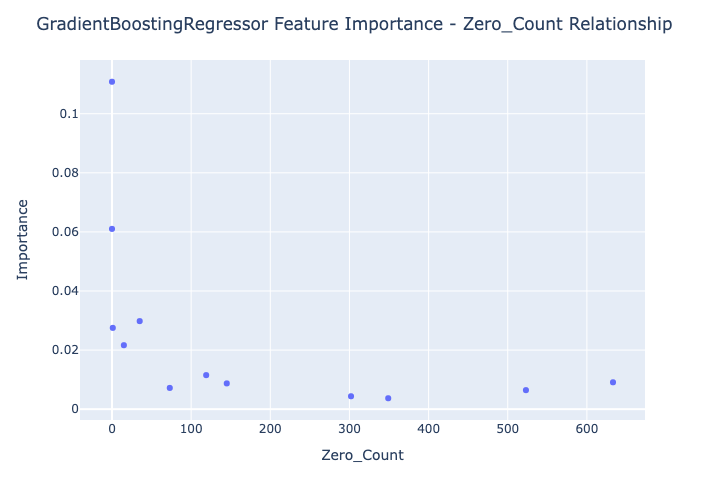

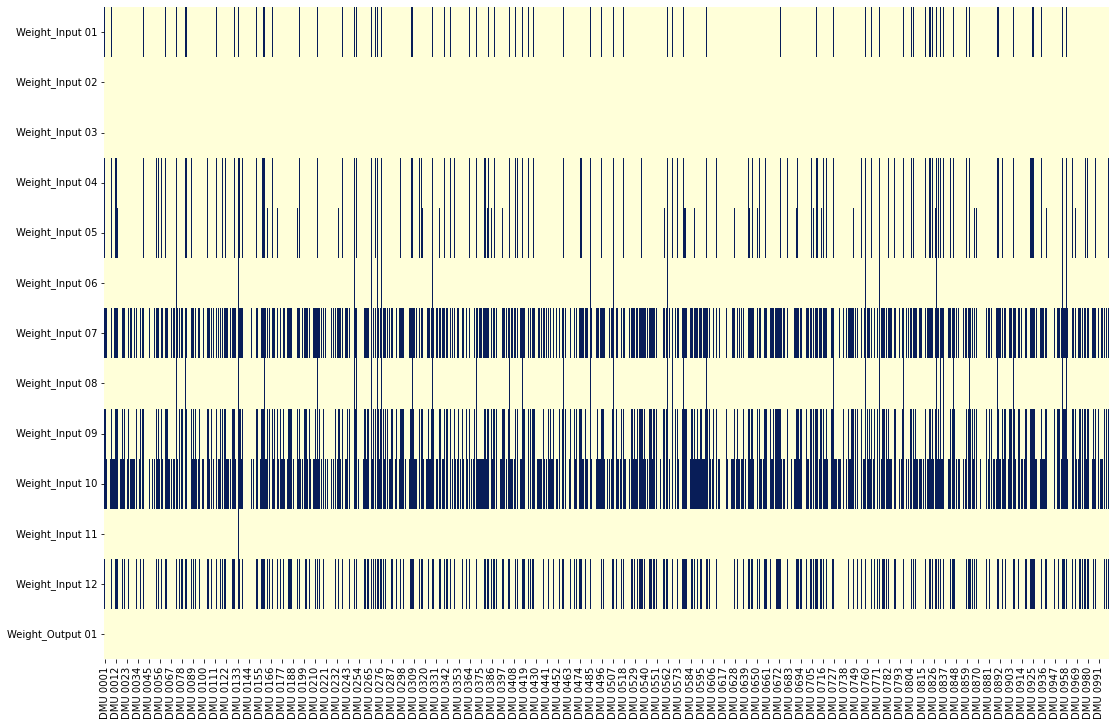

In [32]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_1.xlsx", i=i)

results.append(r)

In [18]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7171  0.6779  0.0392      5.7816           False
1        0.7450  0.7397  0.0053      0.7158            True
2        0.5841  0.5786  0.0055      0.9482            True
3        0.7271  0.7492 -0.0221     -2.9509            True
4        0.6222  0.6600 -0.0378     -5.7287           False
..          ...     ...     ...         ...             ...
195      0.4262  0.4118  0.0145      3.5109           False
196      0.6579  0.6580 -0.0001     -0.0169            True
197      0.5183  0.5145  0.0038      0.7422            True
198      0.5408  0.5081  0.0327      6.4305           False
199      0.6626  0.6875 -0.0249     -3.6171           False

[200 rows x 5 columns]
blue:  97
red:  103
rho: 0.9821
p-Value 0.0


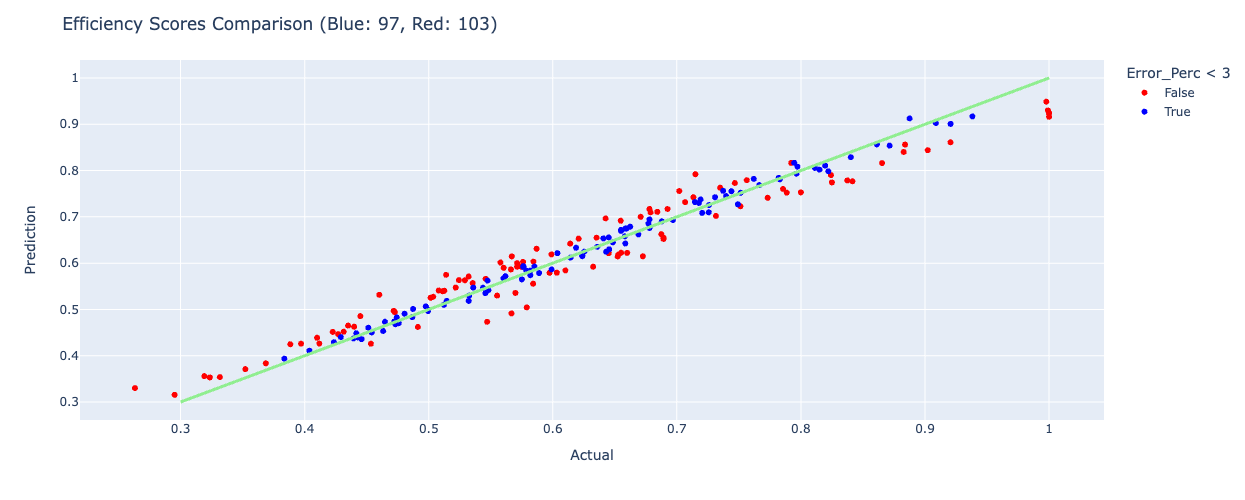

In [36]:
compareML(pipe_gb, y)

blue :  226
red :  774


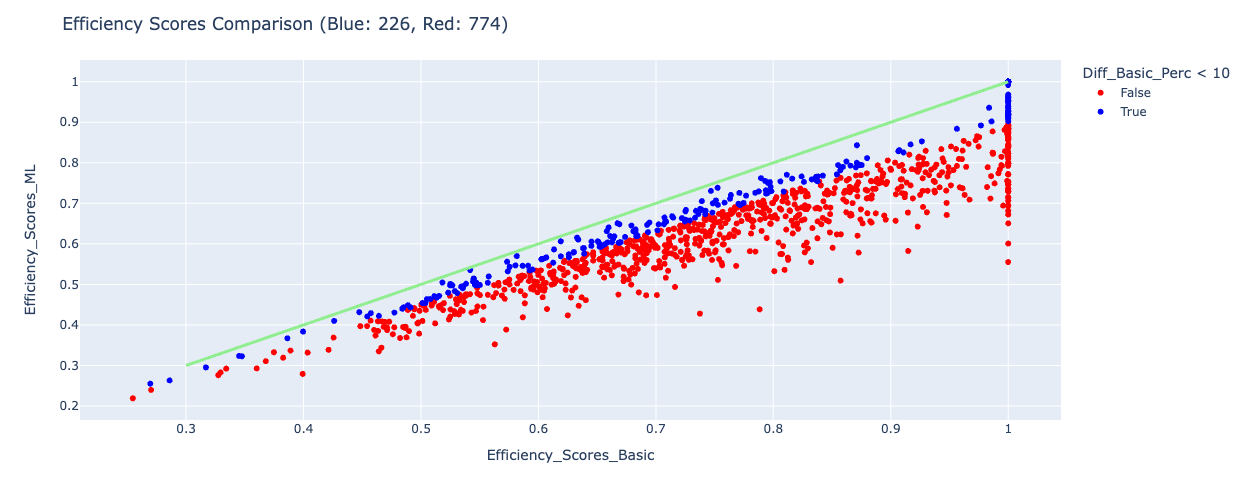

In [39]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_1.xlsx")

### i = 2

In [19]:
i +=1

In [20]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     135
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      61
Weight_Input 05     104
Weight_Input 06      31
Weight_Input 07     248
Weight_Input 08       2
Weight_Input 09     648
Weight_Input 10      96
Weight_Input 11       9
Weight_Input 12     552
Weight_Output 01      0
dtype: int64
Total Zeros:  1887
neg_mean_squared_error: -0.0009590860004778323
neg_root_mean_squared_error: -0.030732585638491516
r2: 0.953312865728765
grid.best_score:  -0.023996854672094076
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

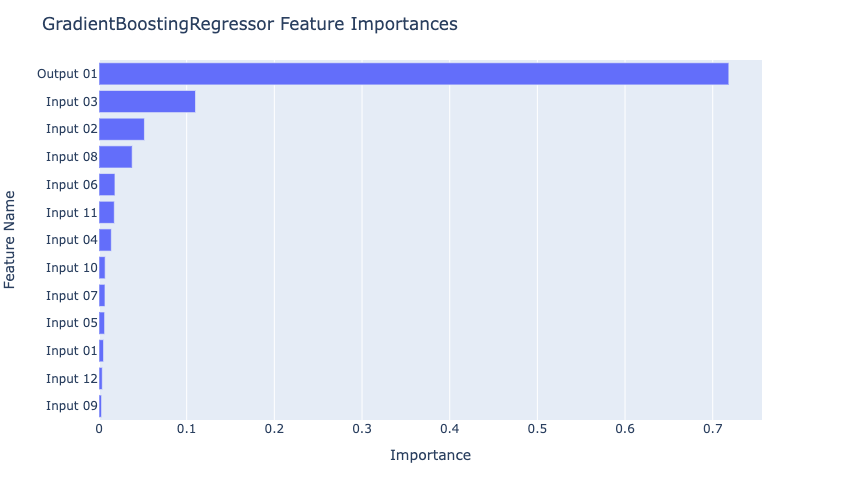

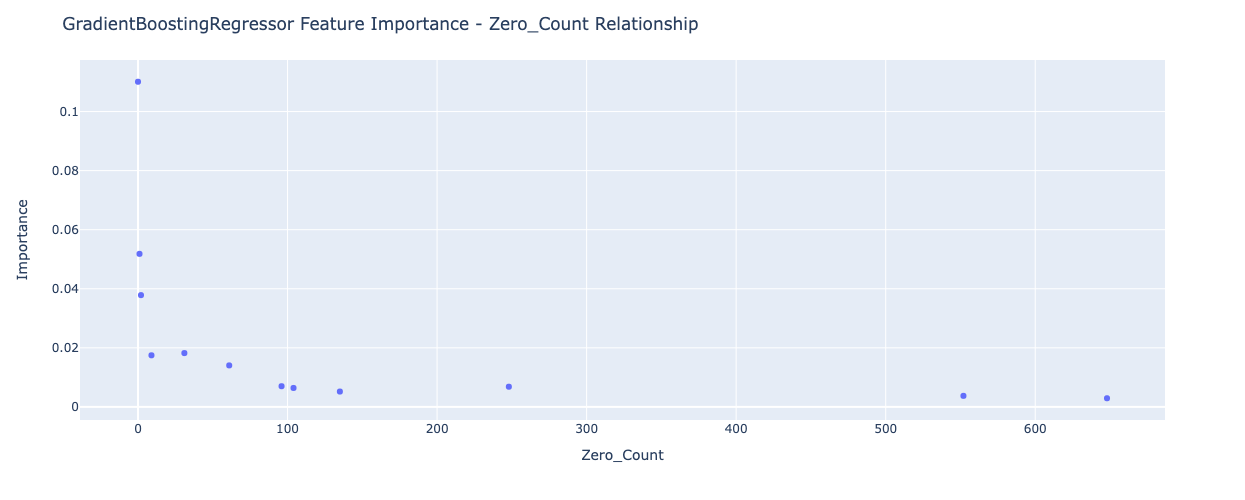

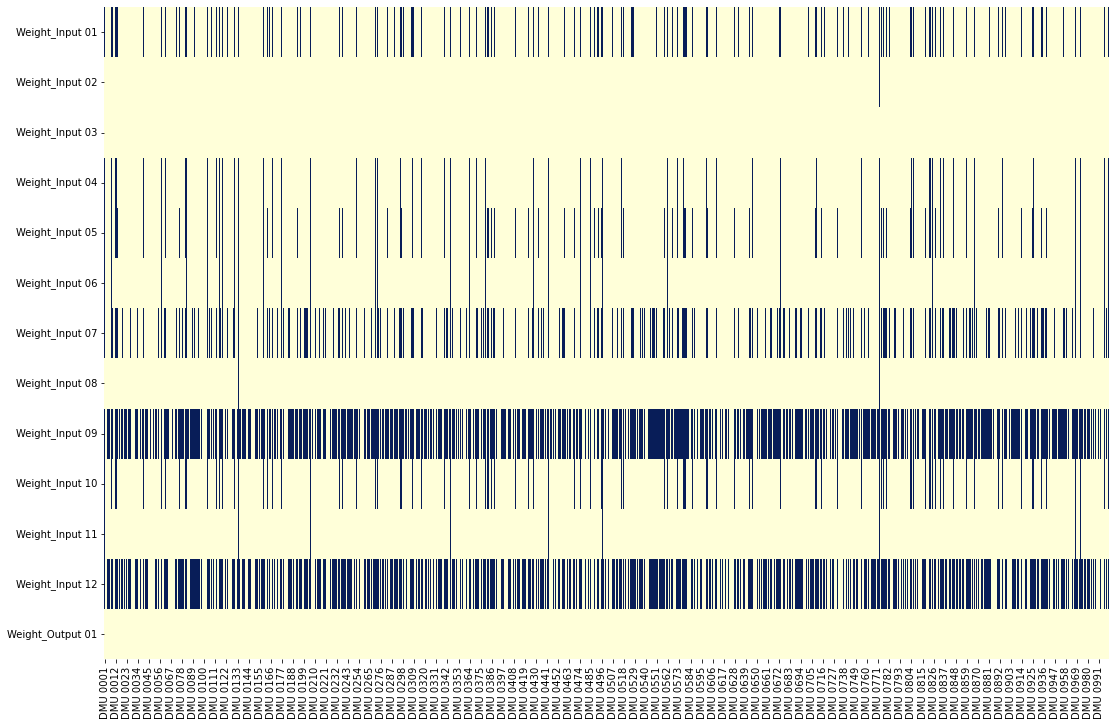

In [42]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_2.xlsx", i=i)
results.append(r)

In [21]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7353  0.6846  0.0506      7.3975           False
1        0.7524  0.7446  0.0078      1.0480            True
2        0.5930  0.5961 -0.0031     -0.5166            True
3        0.7372  0.7526 -0.0154     -2.0524            True
4        0.6296  0.6578 -0.0283     -4.2949           False
..          ...     ...     ...         ...             ...
195      0.4148  0.4047  0.0101      2.4968            True
196      0.6745  0.6706  0.0039      0.5830            True
197      0.5215  0.5139  0.0076      1.4820            True
198      0.5379  0.5270  0.0109      2.0676            True
199      0.6813  0.7135 -0.0322     -4.5183           False

[200 rows x 5 columns]
blue:  102
red:  98
rho: 0.9851
p-Value 0.0


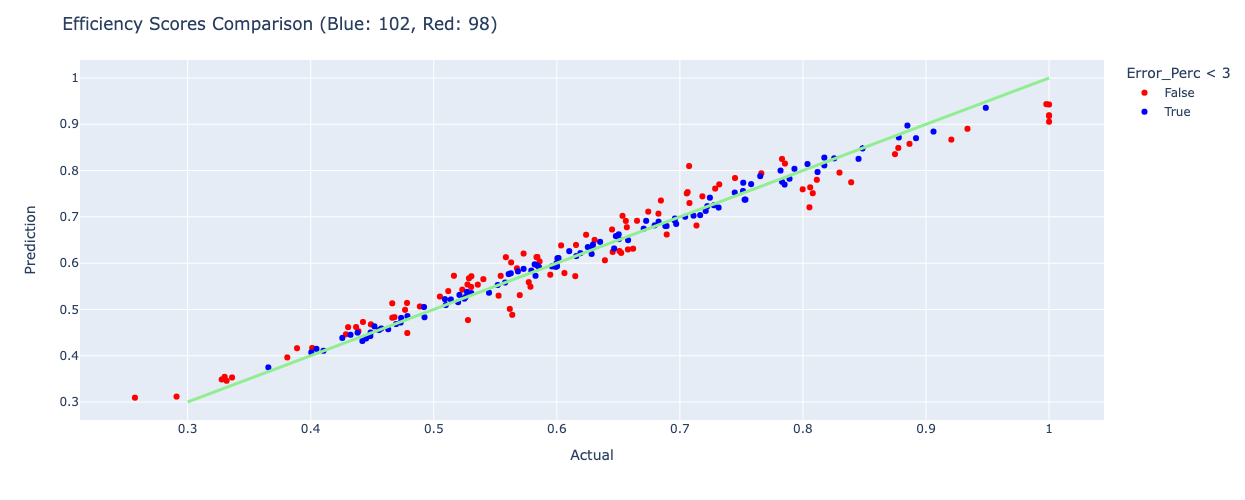

In [45]:
compareML(pipe_gb, y)

blue :  246
red :  754


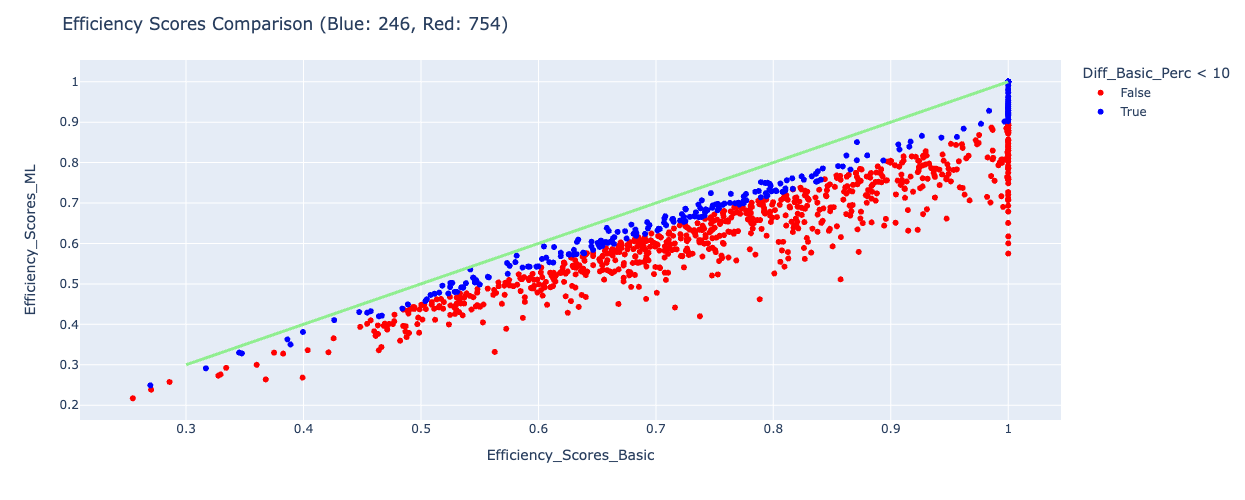

blue :  994
red :  6


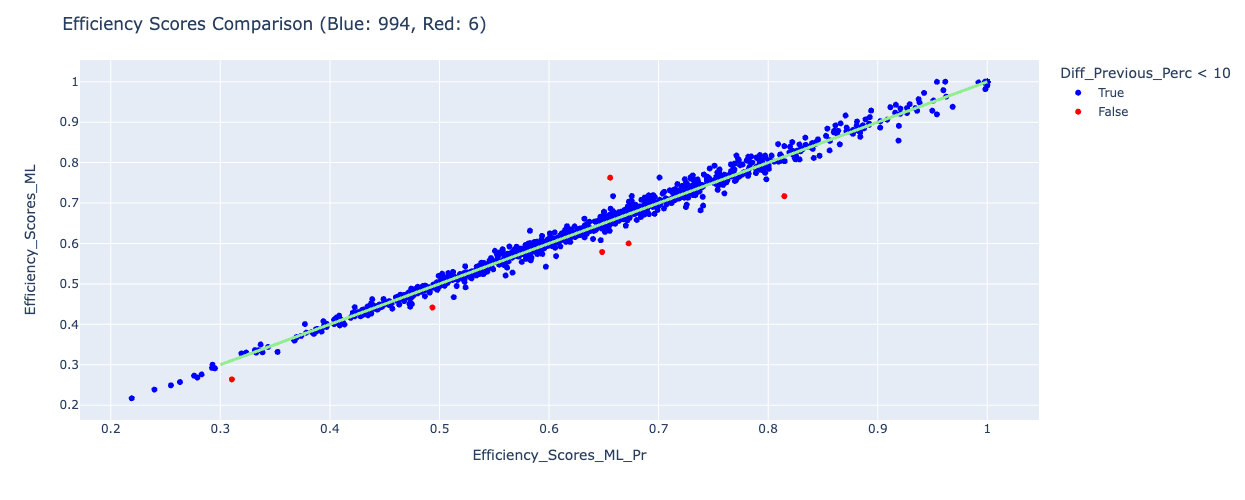

In [46]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_2.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_1.xlsx")

### i = 3

In [22]:
i +=1

In [23]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     174
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      56
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     112
Weight_Input 08       2
Weight_Input 09     695
Weight_Input 10      98
Weight_Input 11      13
Weight_Input 12     580
Weight_Output 01      0
dtype: int64
Total Zeros:  1860
neg_mean_squared_error: -0.0010033813062310234
neg_root_mean_squared_error: -0.03152024302540109
r2: 0.951614979481249
grid.best_score:  -0.02477100716341915
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, mi

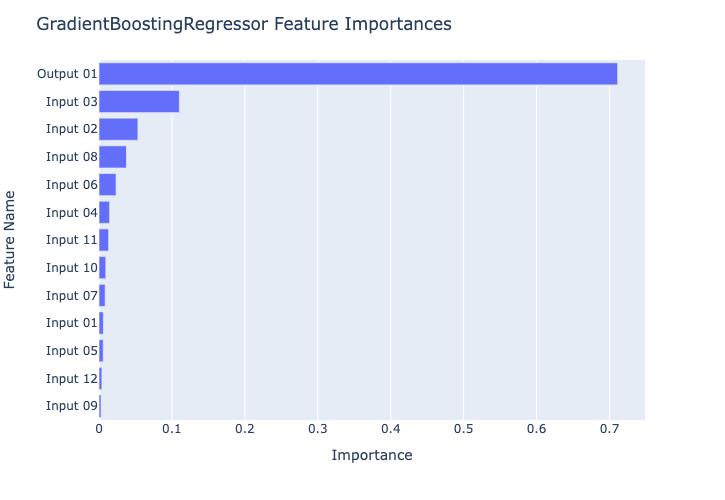

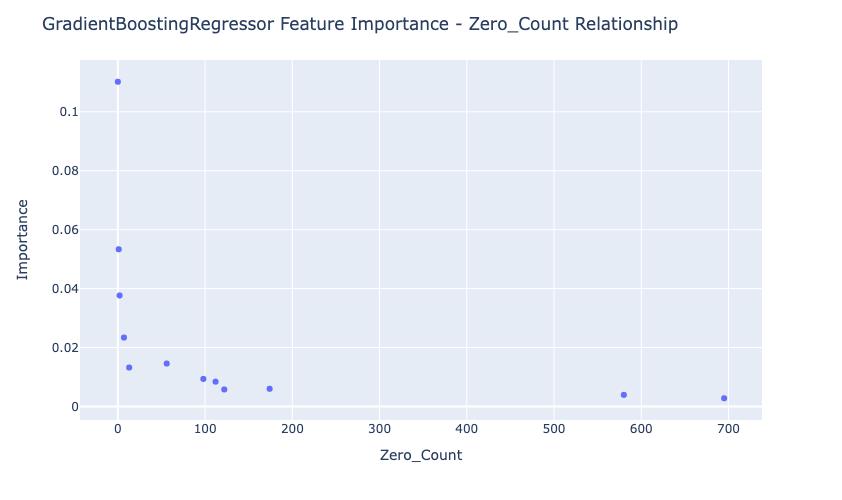

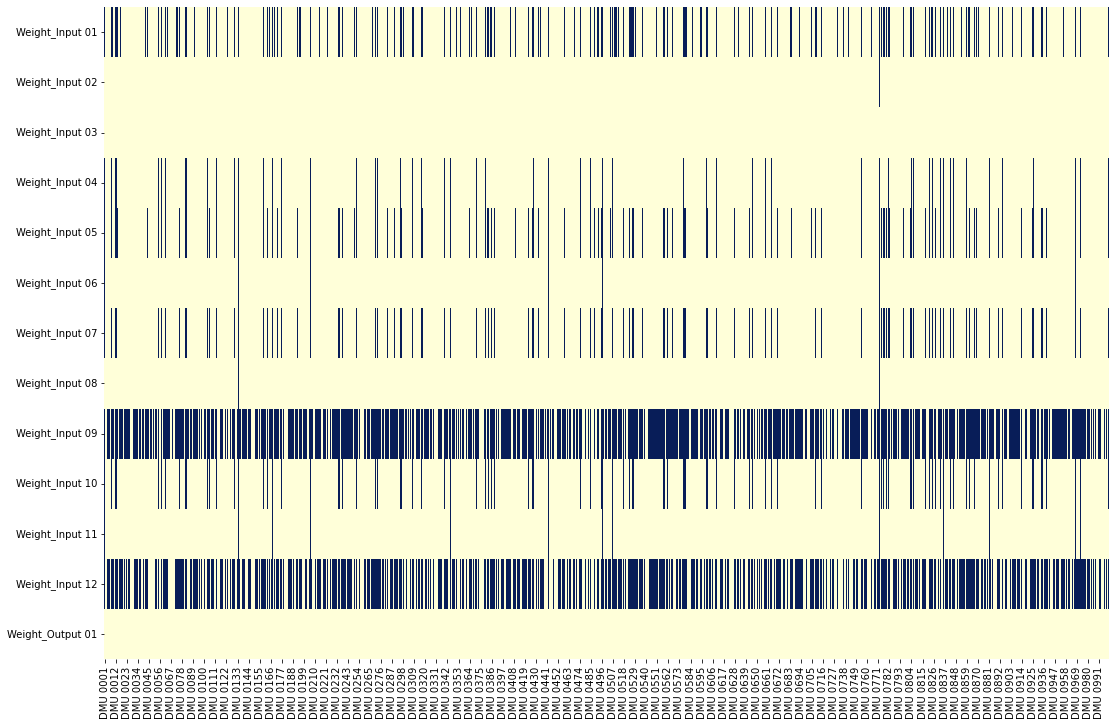

In [50]:
pipe_gb, r, y,df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_3.xlsx", i=i)
results.append(r)

In [24]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7127  0.6850  0.0277      4.0396           False
1        0.7537  0.7446  0.0091      1.2264            True
2        0.5926  0.6035 -0.0109     -1.8050            True
3        0.7312  0.7526 -0.0214     -2.8483            True
4        0.6163  0.6578 -0.0416     -6.3164           False
..          ...     ...     ...         ...             ...
195      0.4145  0.3921  0.0224      5.7129           False
196      0.6656  0.6706 -0.0050     -0.7464            True
197      0.5218  0.5141  0.0077      1.5020            True
198      0.5374  0.5270  0.0104      1.9733            True
199      0.6842  0.7135 -0.0293     -4.1122           False

[200 rows x 5 columns]
blue:  102
red:  98
rho: 0.9863
p-Value 0.0


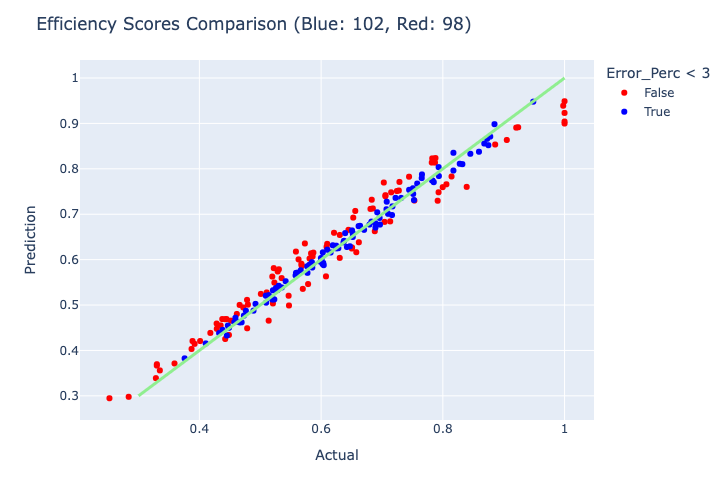

In [52]:
compareML(pipe_gb, y)

blue :  234
red :  766


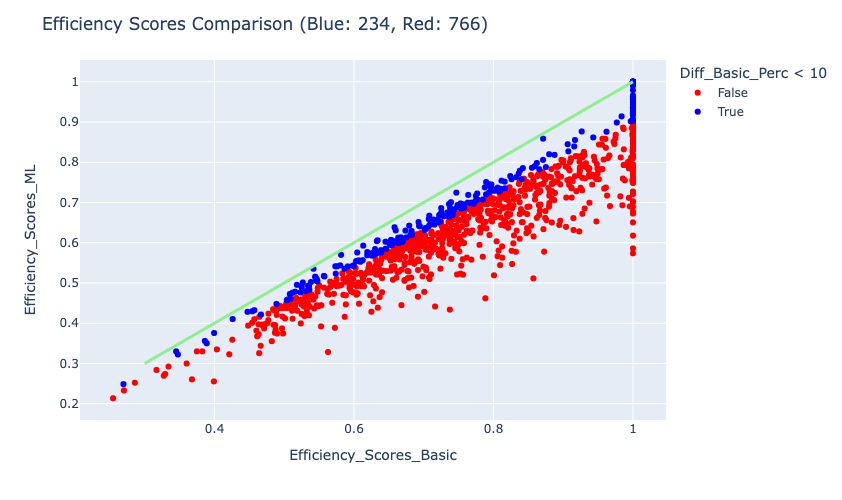

blue :  999
red :  1


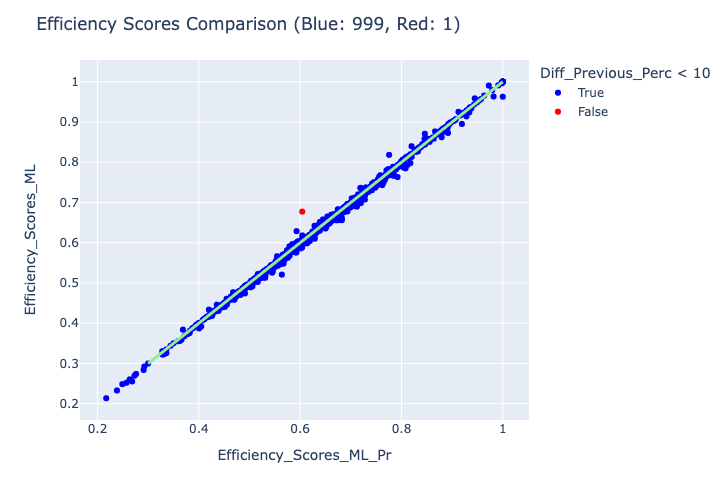

In [54]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_3.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_2.xlsx")

### i = 4

In [25]:
i +=1

In [26]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     124
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     158
Weight_Input 06       7
Weight_Input 07     104
Weight_Input 08       2
Weight_Input 09     682
Weight_Input 10      94
Weight_Input 11      23
Weight_Input 12     569
Weight_Output 01      0
dtype: int64
Total Zeros:  1782
neg_mean_squared_error: -0.0009758604402618377
neg_root_mean_squared_error: -0.03114129226640162
r2: 0.9526329992041557
grid.best_score:  -0.02407577862452921
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, m

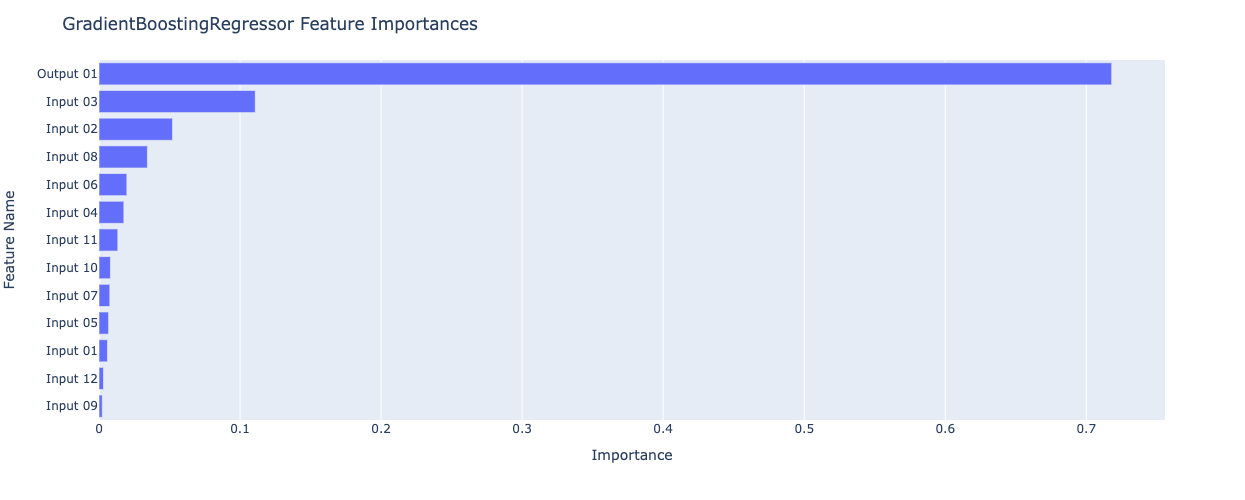

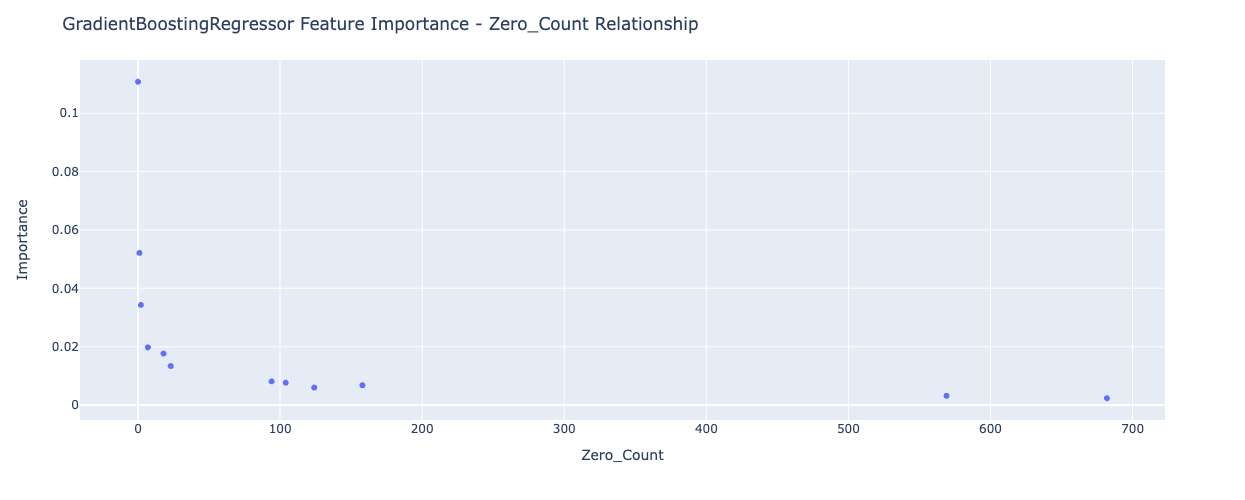

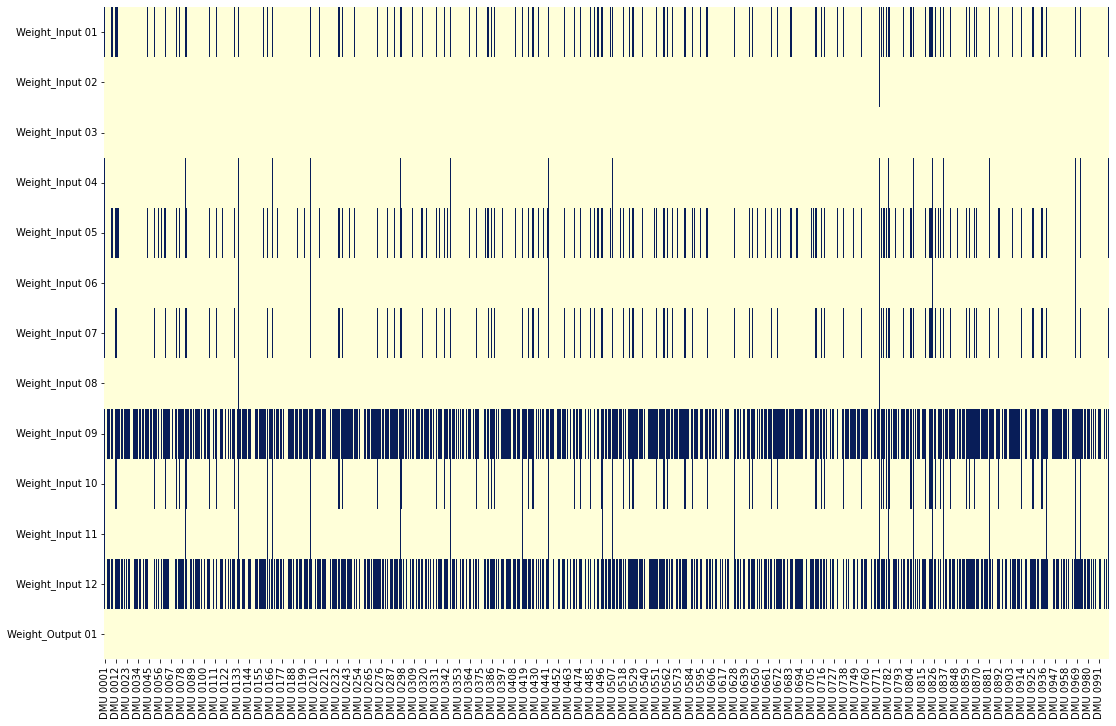

In [57]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_4.xlsx", i=i)
results.append(r)

In [27]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7323  0.6850  0.0473      6.9111           False
1        0.7463  0.7446  0.0017      0.2227            True
2        0.5949  0.5957 -0.0008     -0.1388            True
3        0.7338  0.7526 -0.0189     -2.5084            True
4        0.6266  0.6569 -0.0303     -4.6089           False
..          ...     ...     ...         ...             ...
195      0.4142  0.3921  0.0221      5.6397           False
196      0.6641  0.6706 -0.0064     -0.9606            True
197      0.5241  0.5126  0.0114      2.2319            True
198      0.5373  0.5270  0.0103      1.9514            True
199      0.6805  0.7135 -0.0330     -4.6243           False

[200 rows x 5 columns]
blue:  116
red:  84
rho: 0.9867
p-Value 0.0


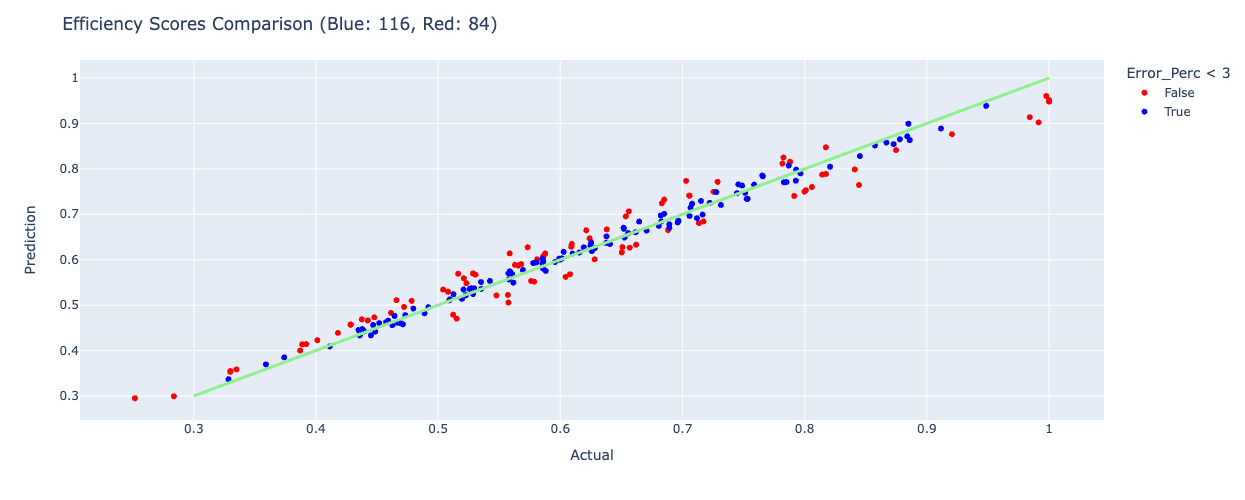

In [59]:
compareML(pipe_gb, y)

blue :  228
red :  772


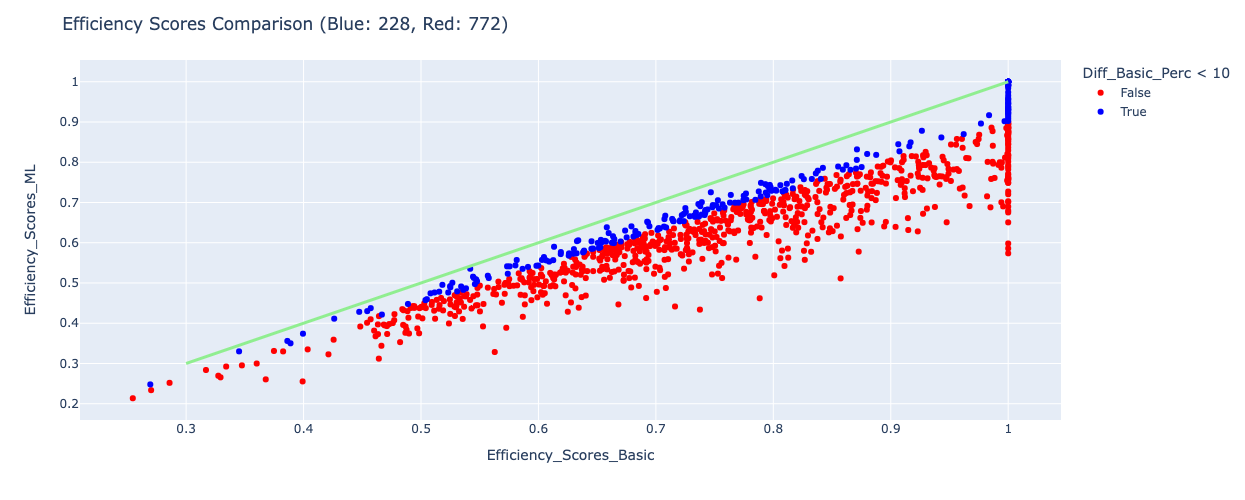

blue :  1000
red :  0


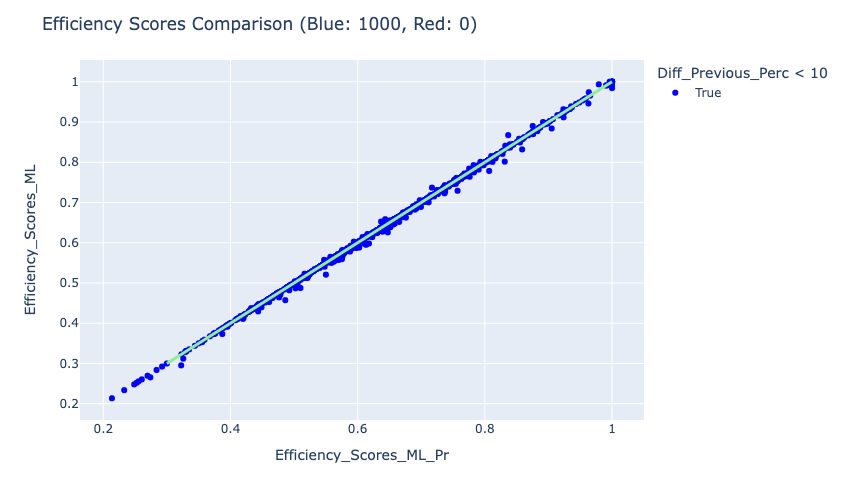

In [60]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_4.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_3.xlsx")

### i = 5

In [28]:
i +=1

In [29]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

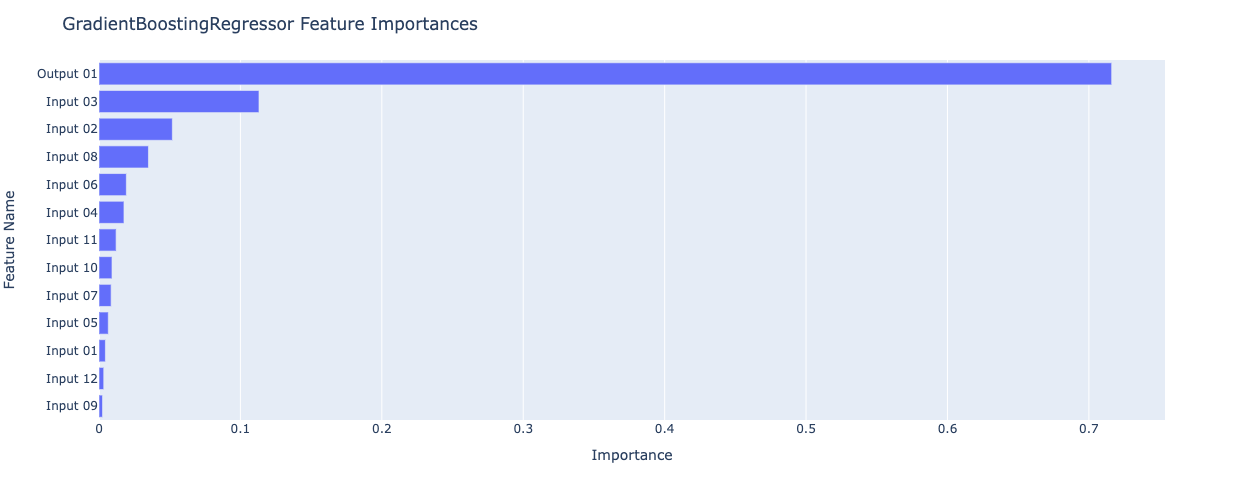

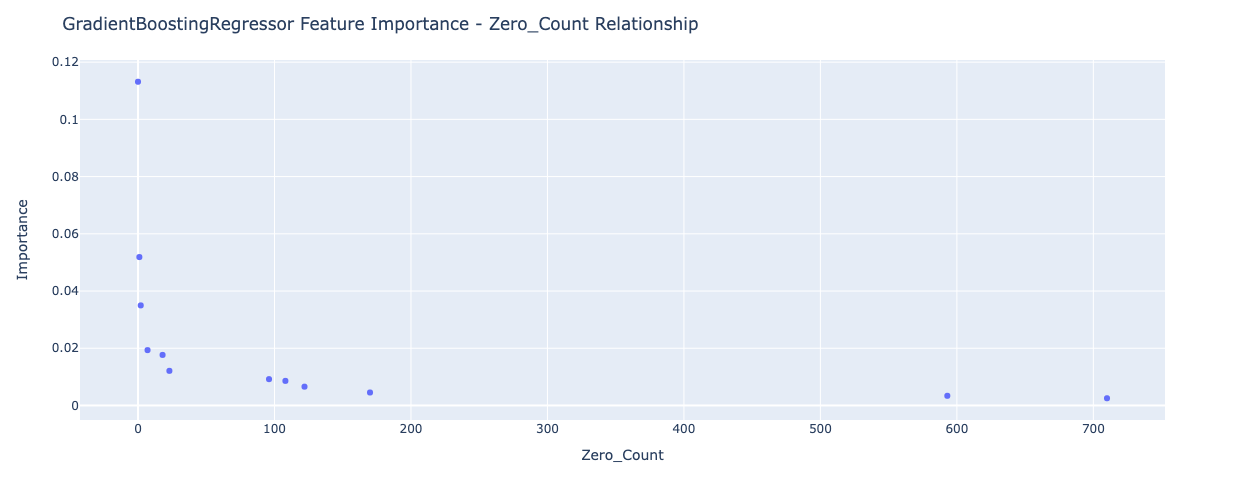

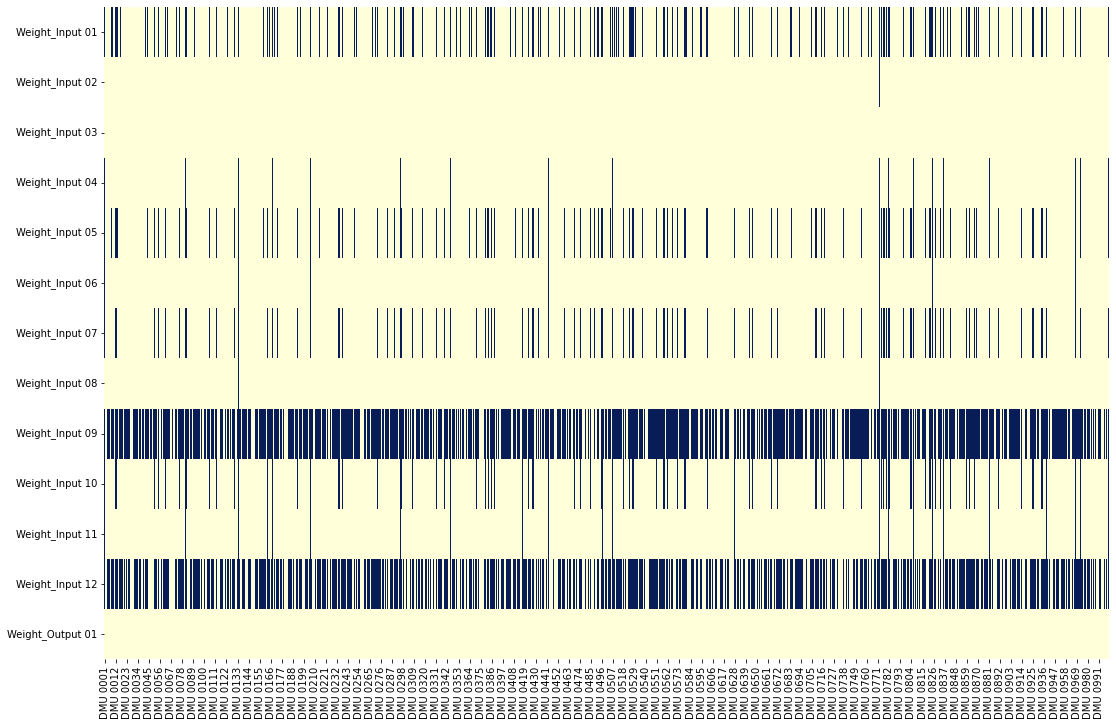

In [63]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_5.xlsx", i=i)
results.append(r)

In [30]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


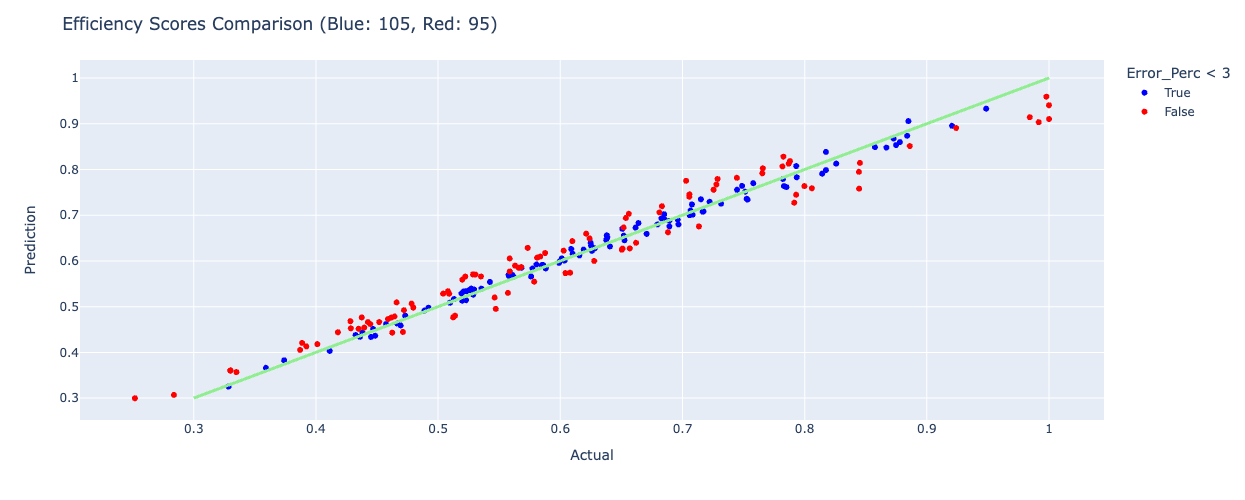

In [65]:
compareML(pipe_gb, y)

blue :  229
red :  771


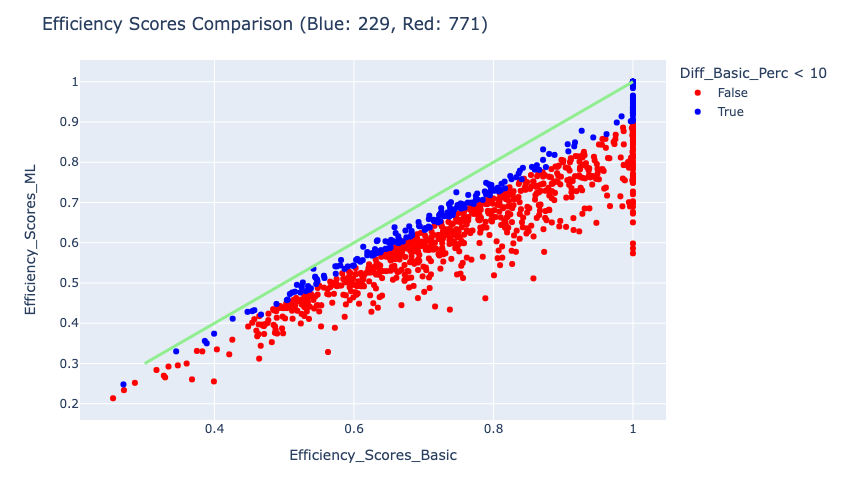

blue :  1000
red :  0


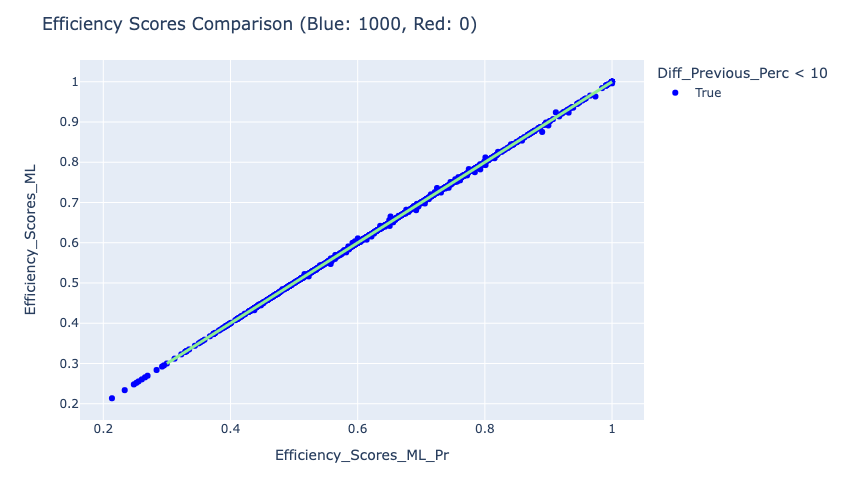

In [66]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_5.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_4.xlsx")

### i = 6

In [31]:
i +=1

In [32]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

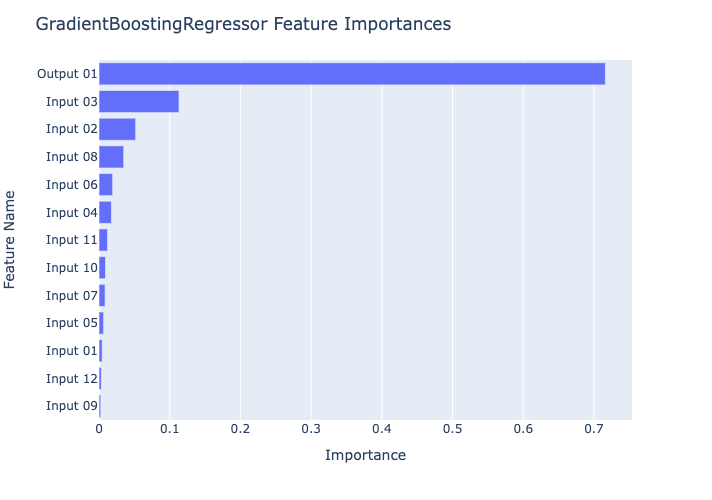

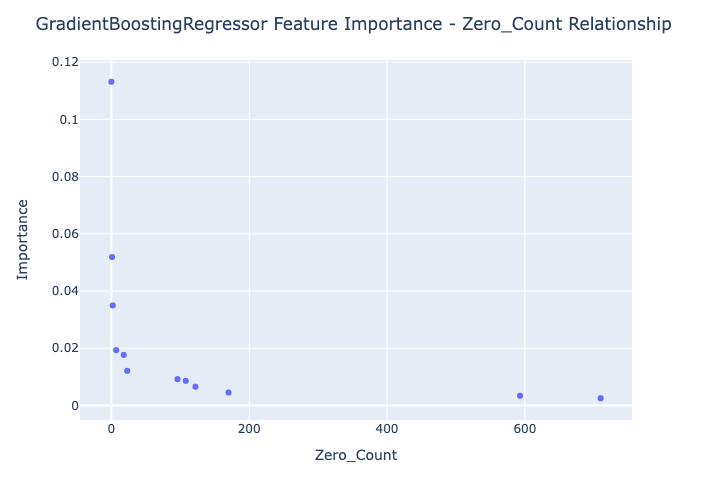

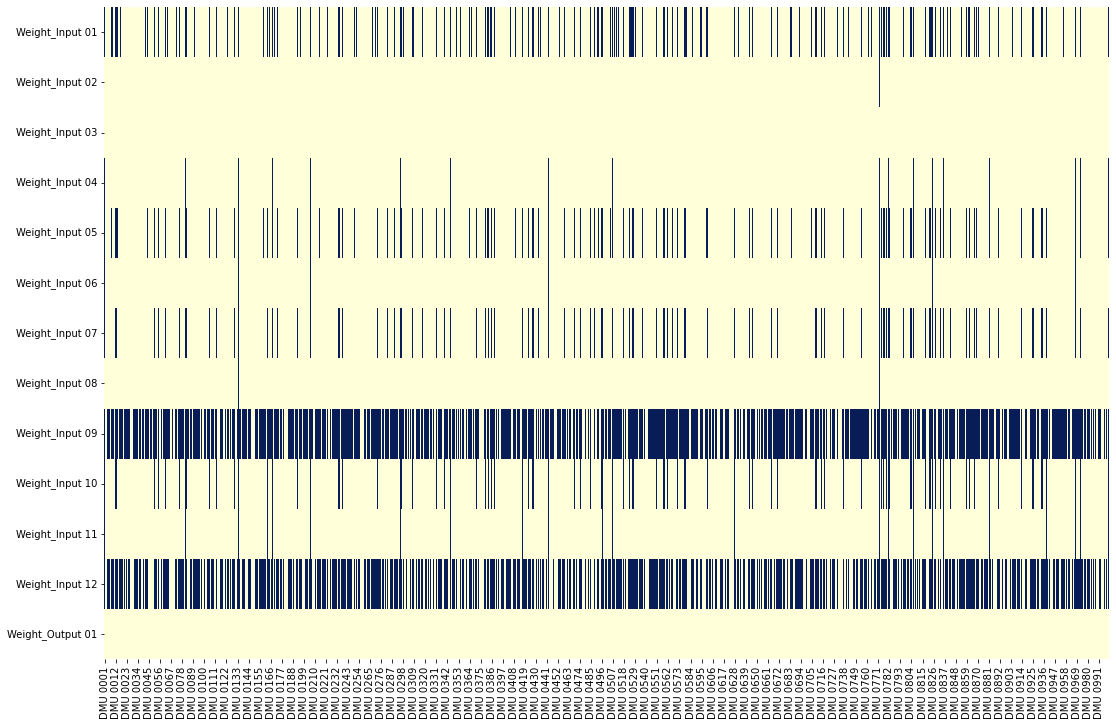

In [69]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_6.xlsx", i=i)
results.append(r)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


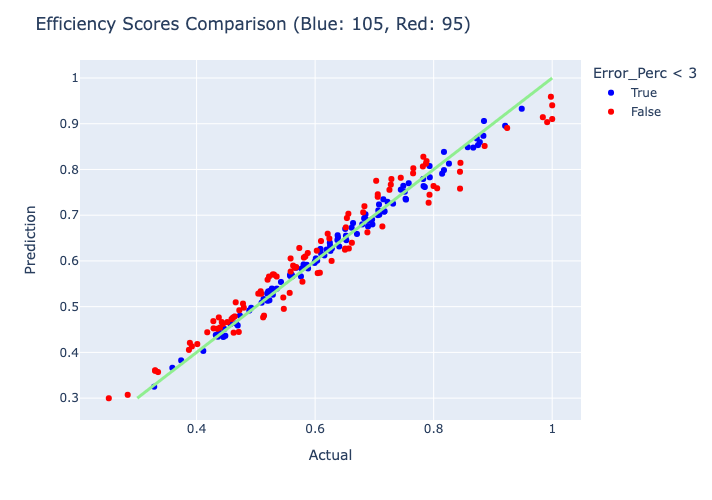

In [70]:
compareML(pipe_gb, y)

In [33]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

blue :  229
red :  771


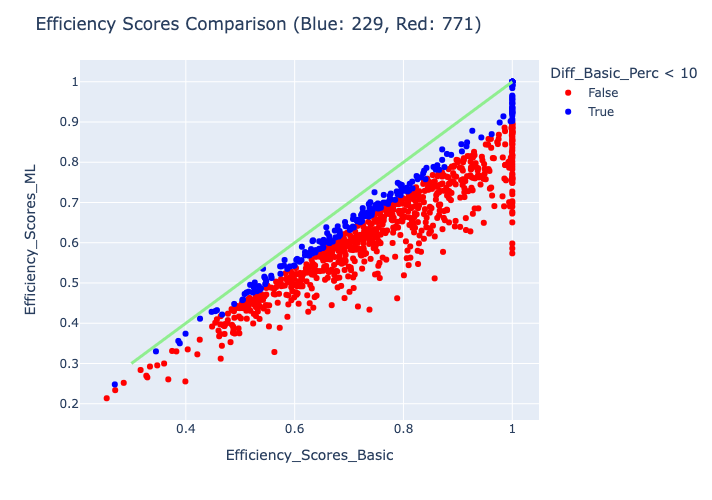

blue :  1000
red :  0


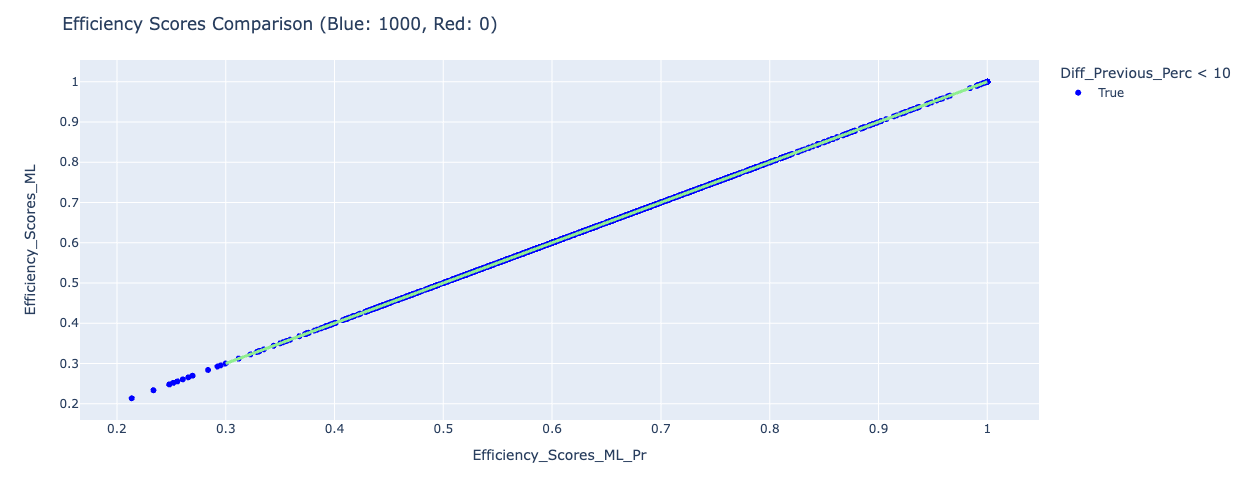

In [72]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_6.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_5.xlsx")

### i = 7

In [34]:
i +=1

In [35]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

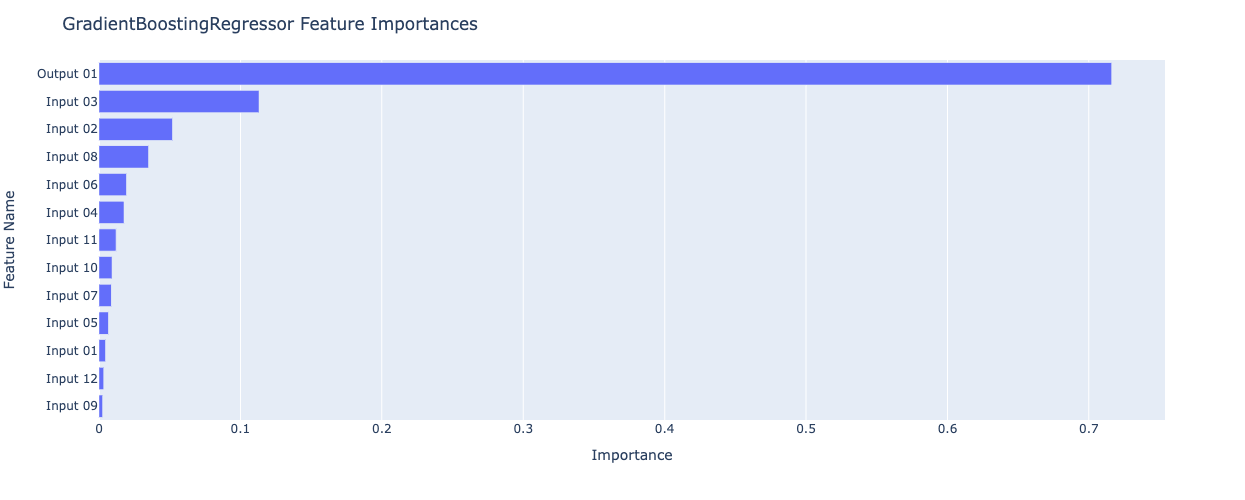

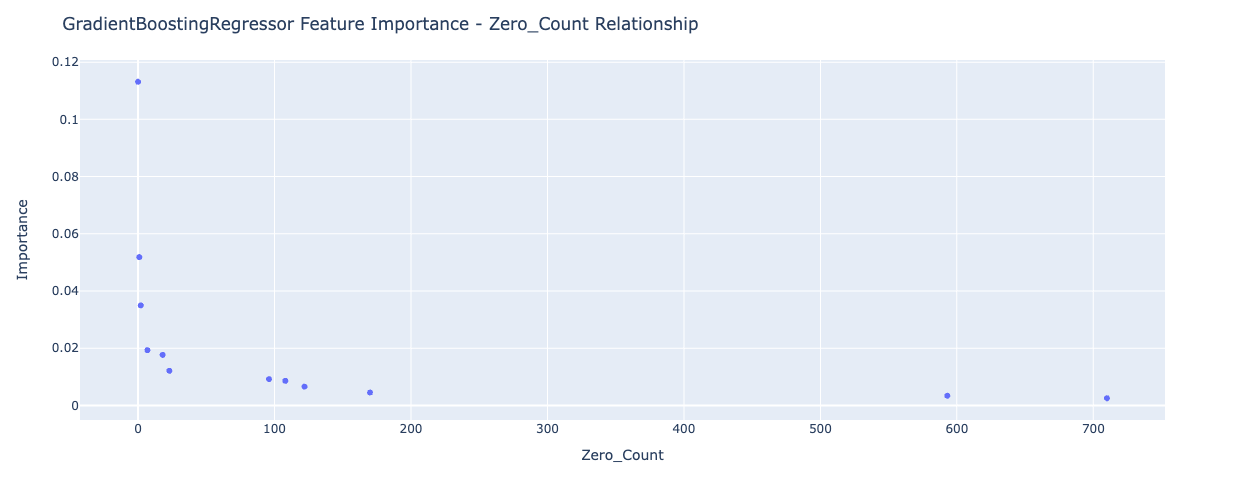

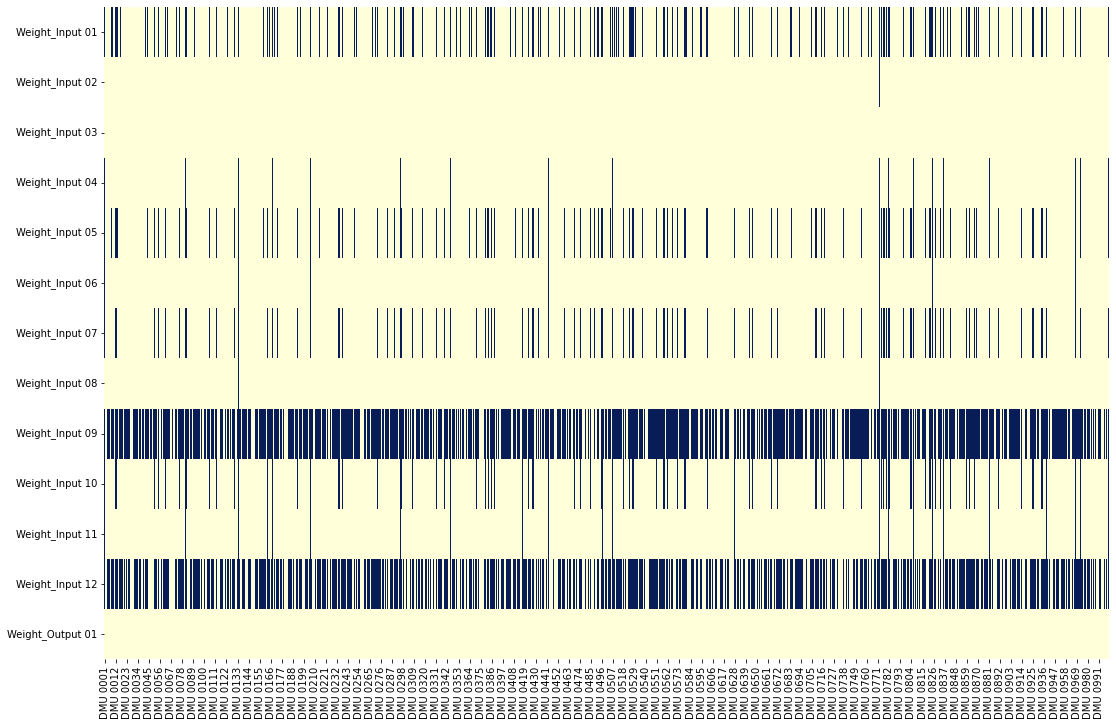

In [75]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_7.xlsx", i=i)
results.append(r)

In [36]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


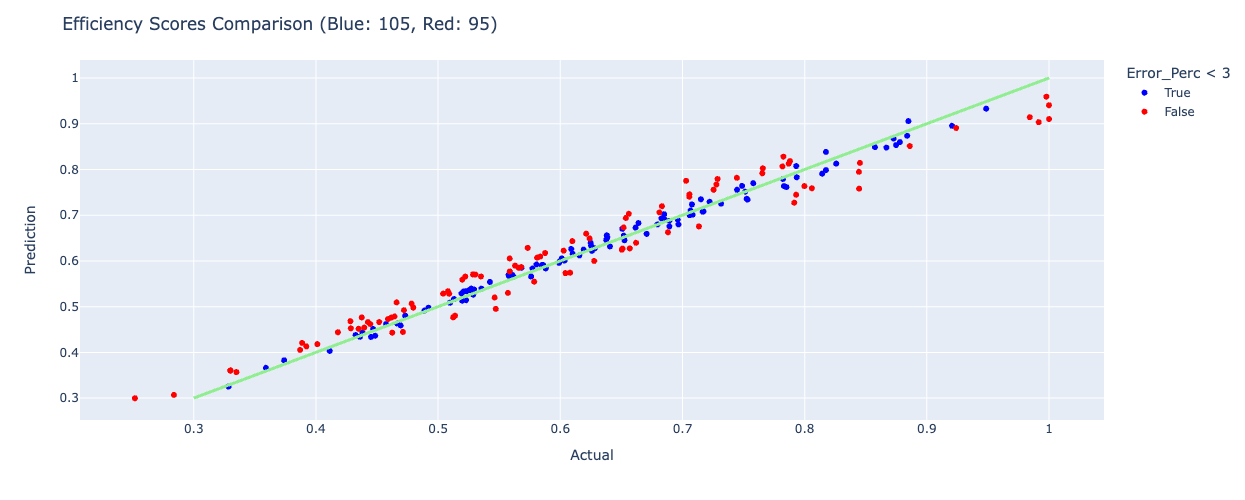

In [77]:
compareML(pipe_gb, y)

blue :  229
red :  771


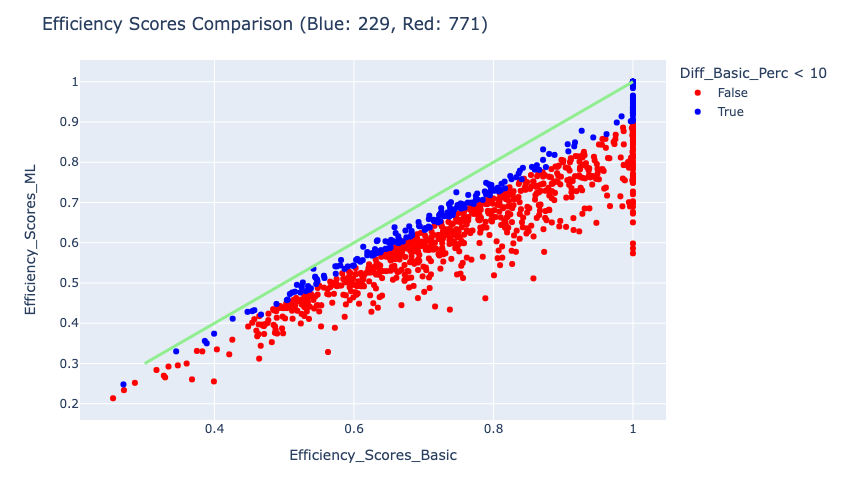

blue :  1000
red :  0


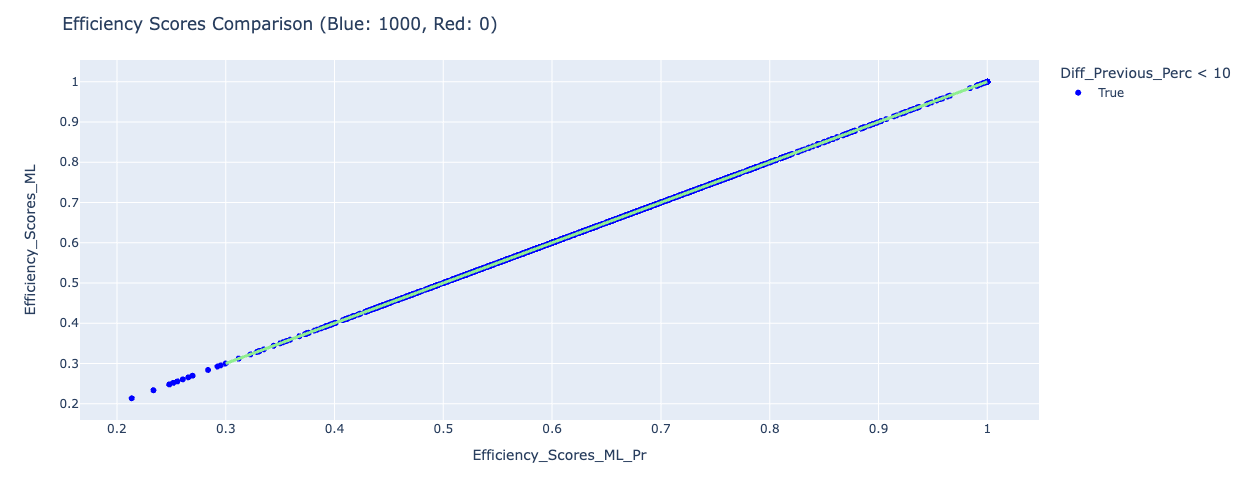

In [78]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_7.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_6.xlsx")

### i = 8

In [37]:
i +=1

In [38]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

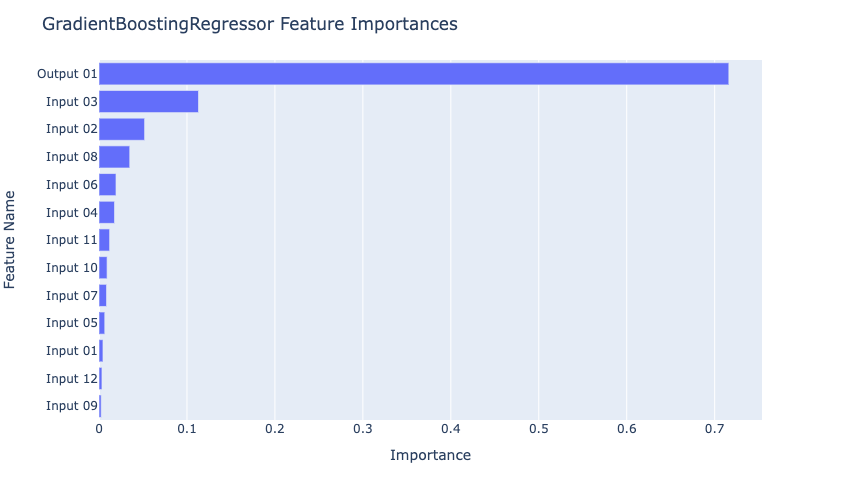

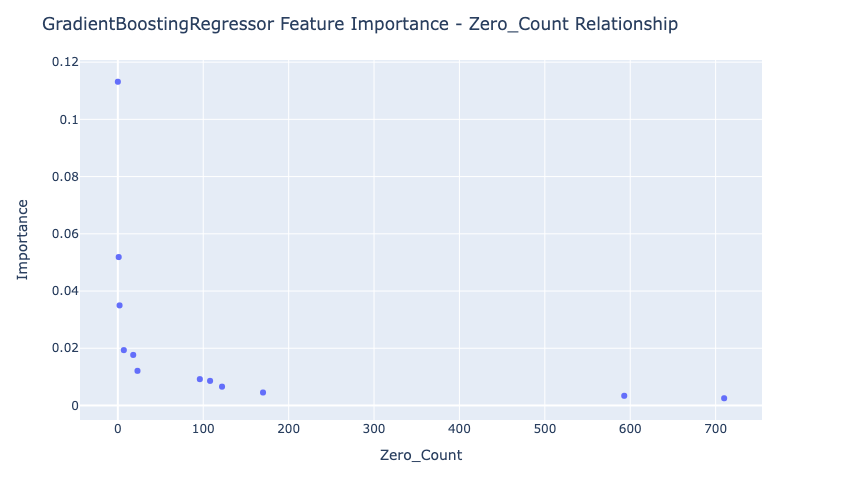

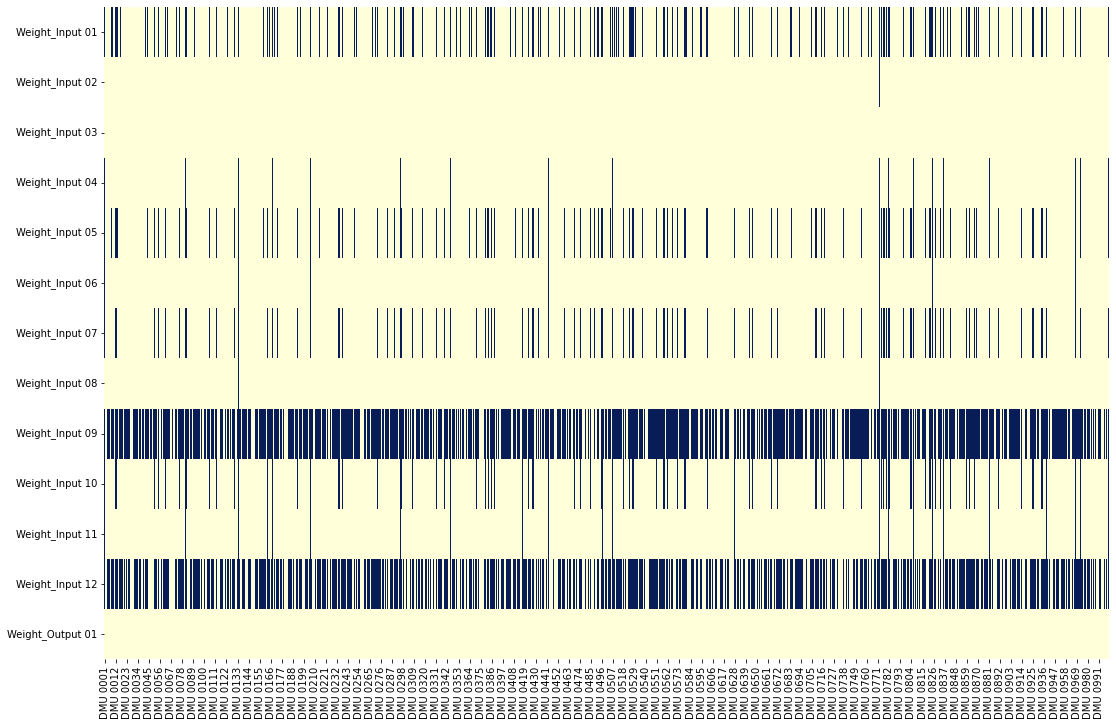

In [81]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_8.xlsx", i=i)
results.append(r)

In [39]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


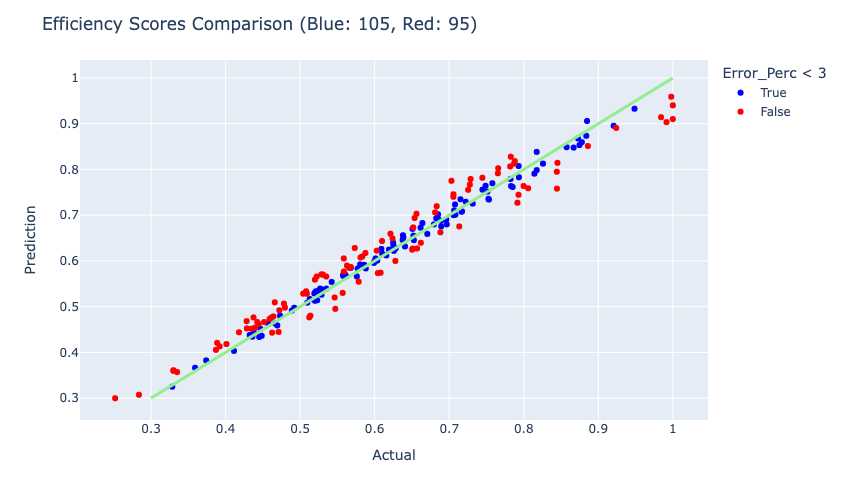

In [83]:
compareML(pipe_gb, y)

blue :  229
red :  771


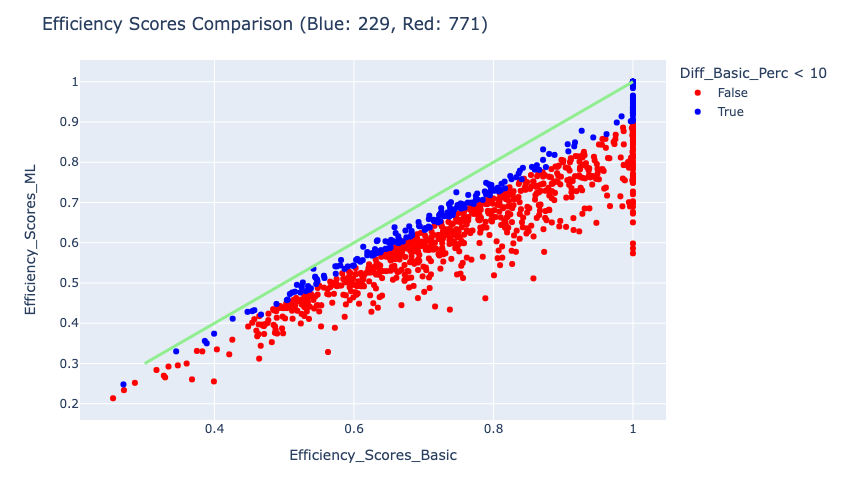

blue :  1000
red :  0


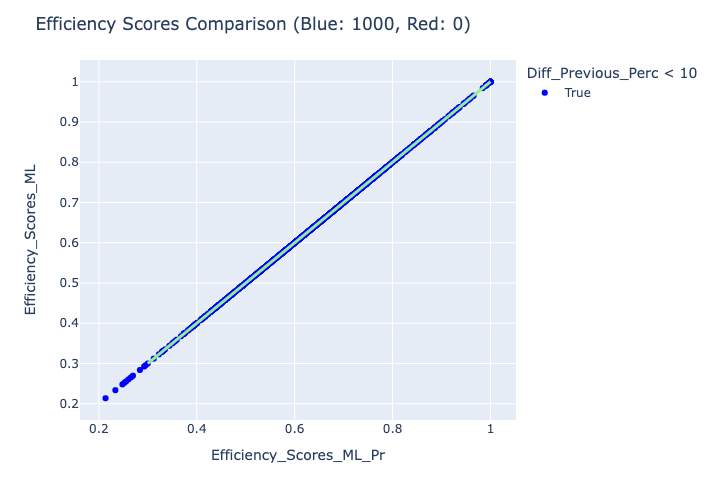

In [84]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_8.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_7.xlsx")

### i = 9

In [40]:
i +=1

In [41]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

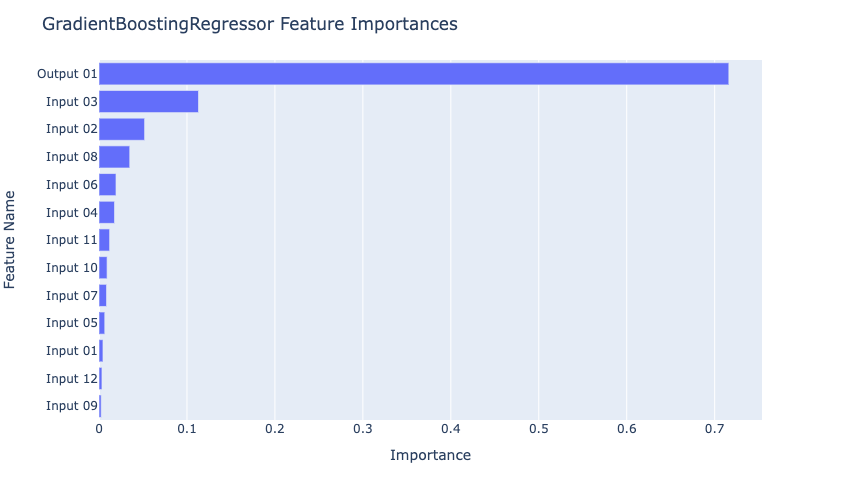

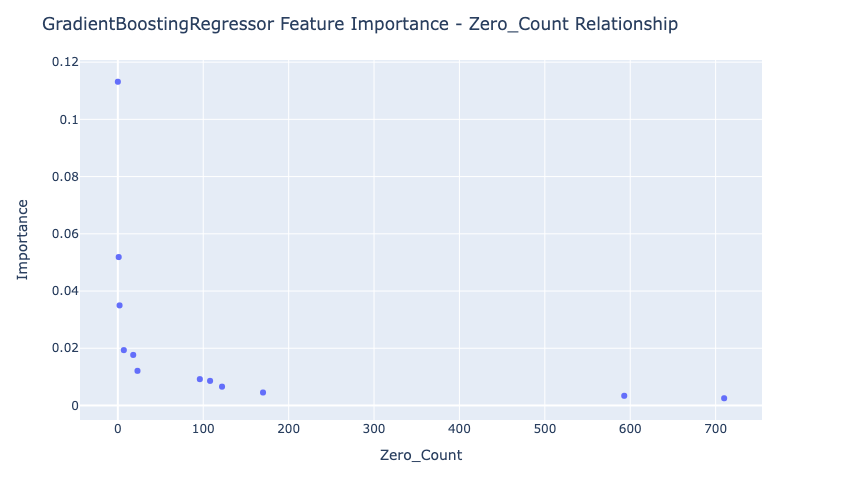

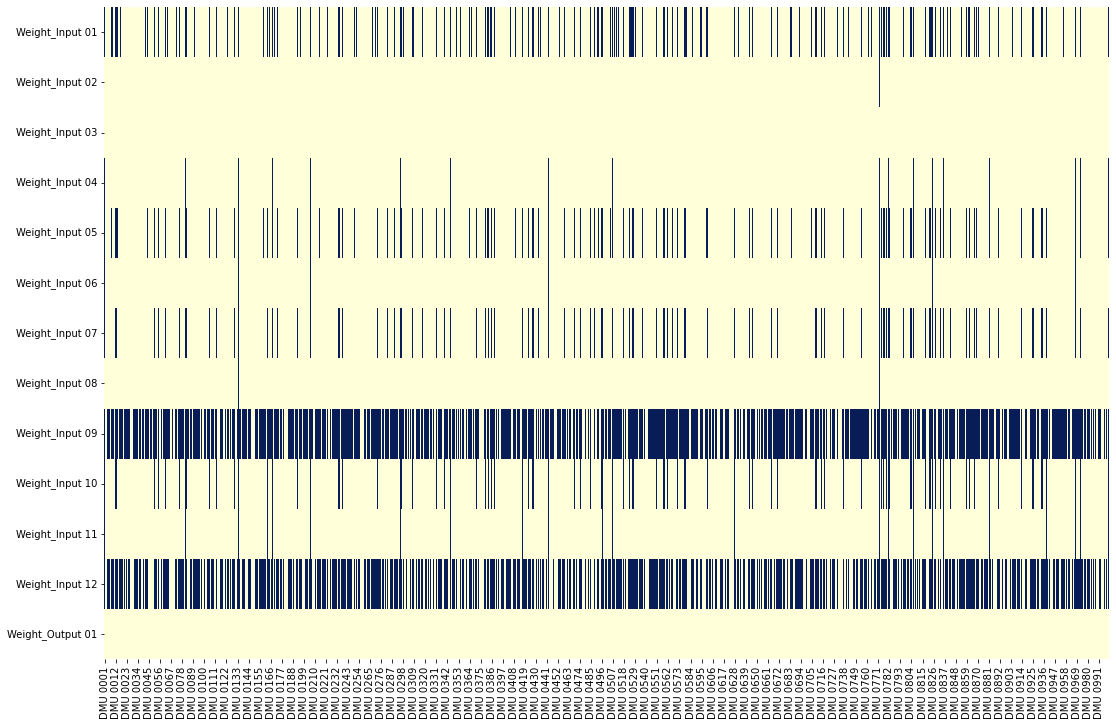

In [87]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_9.xlsx", i=i)
results.append(r)

In [42]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


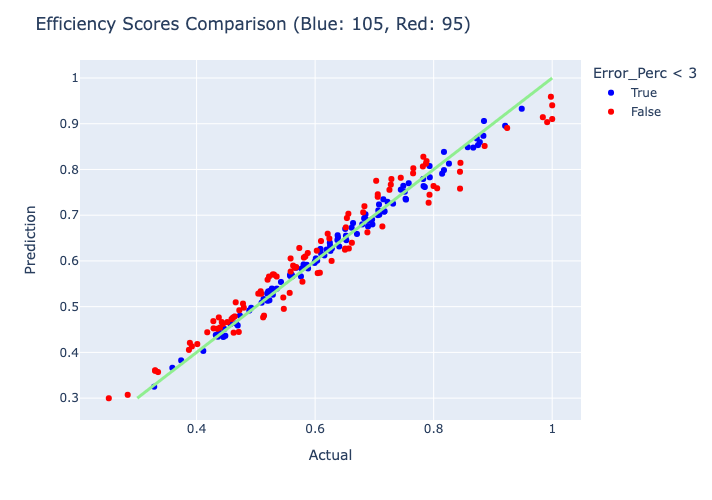

In [89]:
compareML(pipe_gb, y)

blue :  229
red :  771


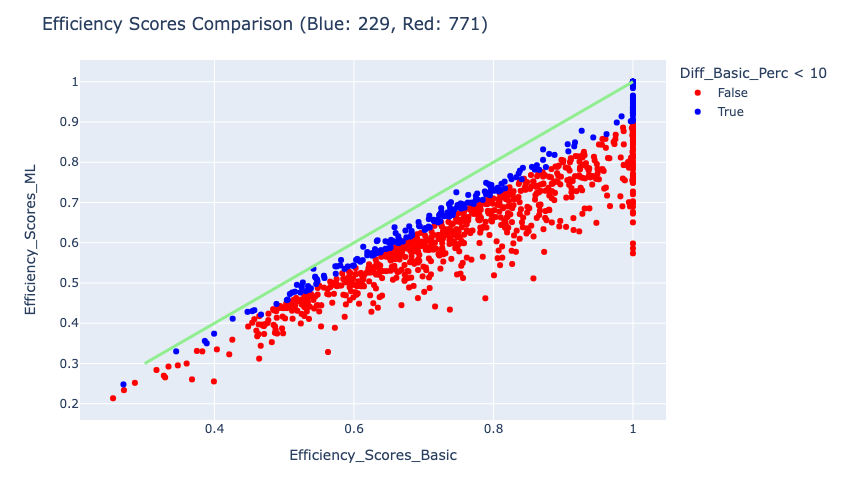

blue :  1000
red :  0


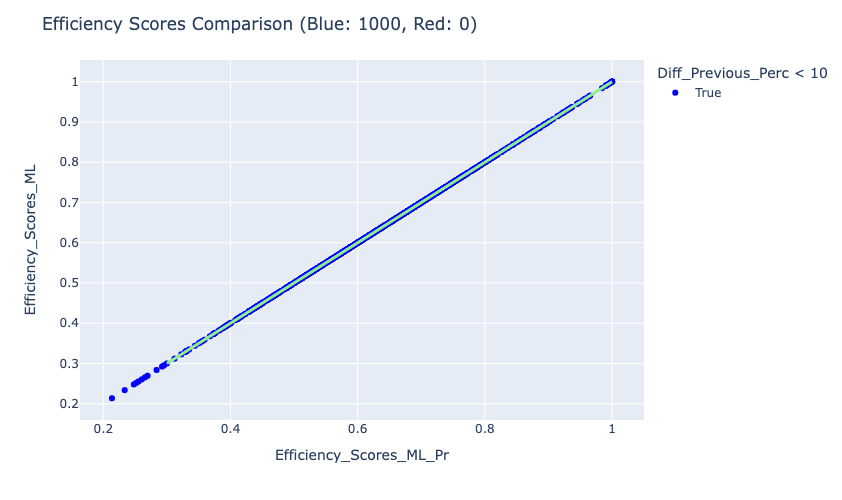

In [90]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_9.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_8.xlsx")

### i = 10

In [43]:
i +=1

In [44]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

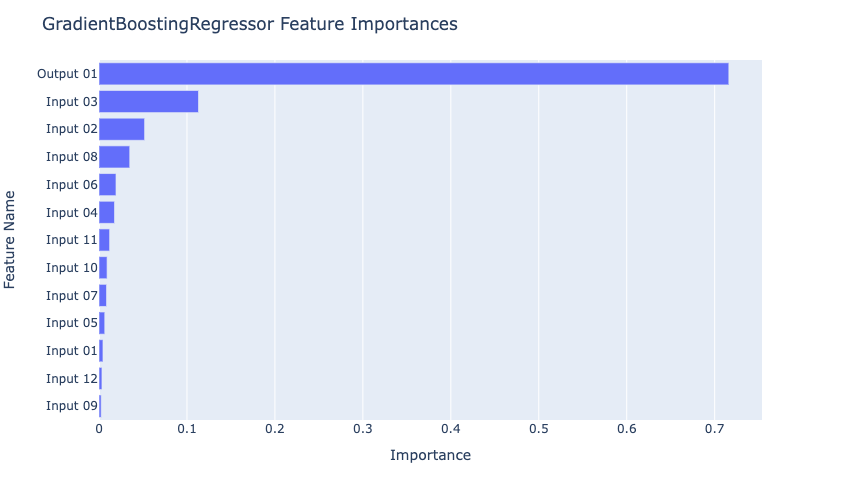

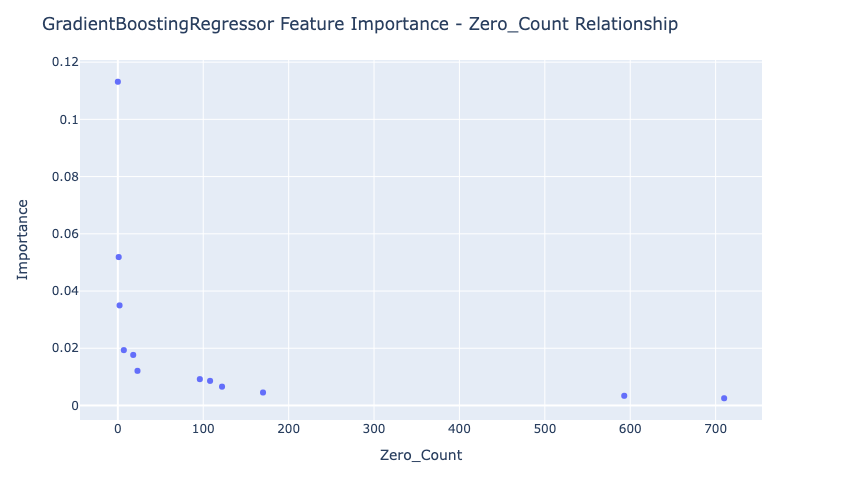

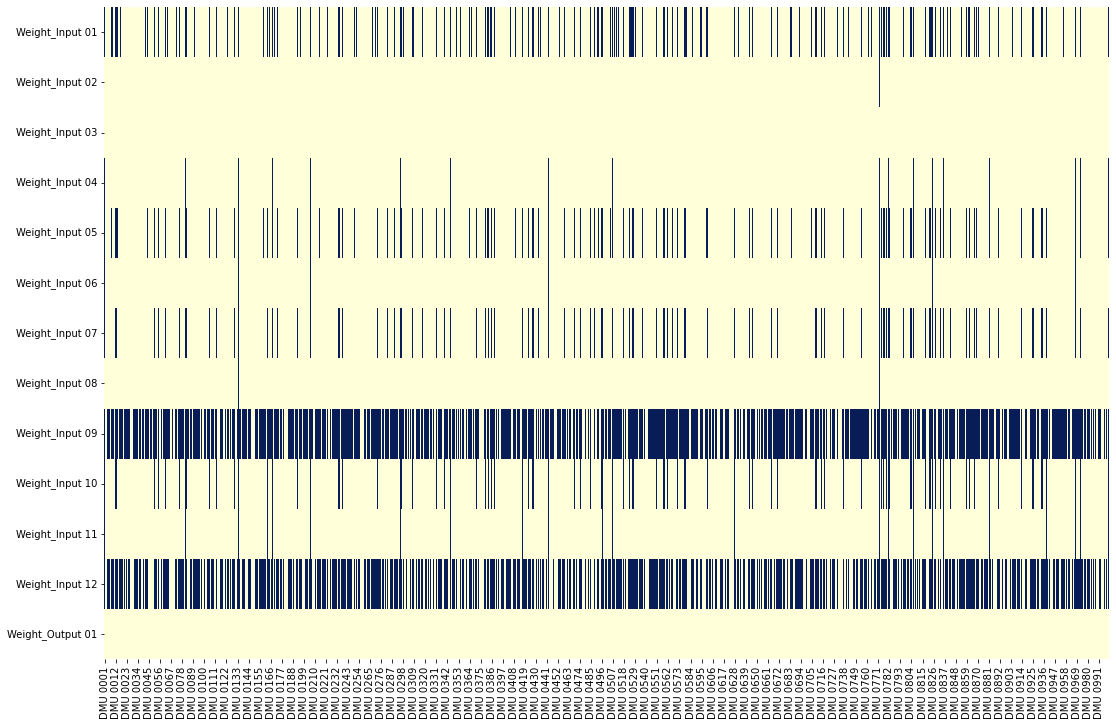

In [93]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_10.xlsx", i=i)
results.append(r)

In [45]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


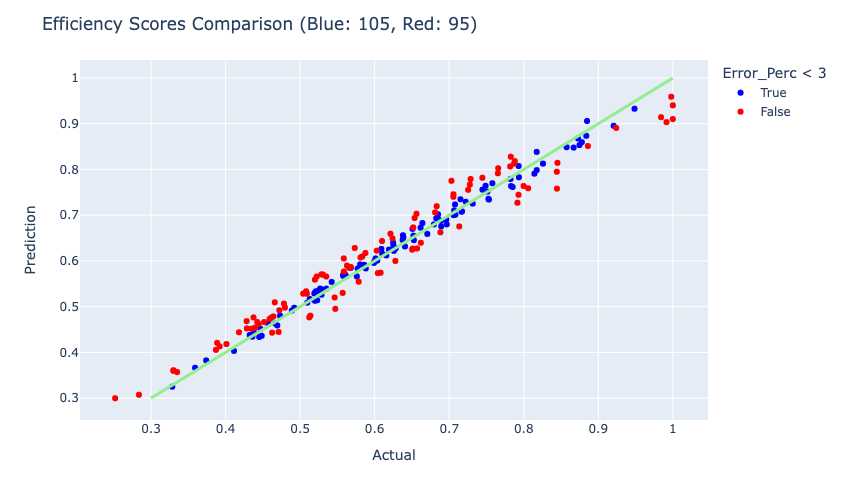

In [95]:
compareML(pipe_gb, y)

blue :  229
red :  771


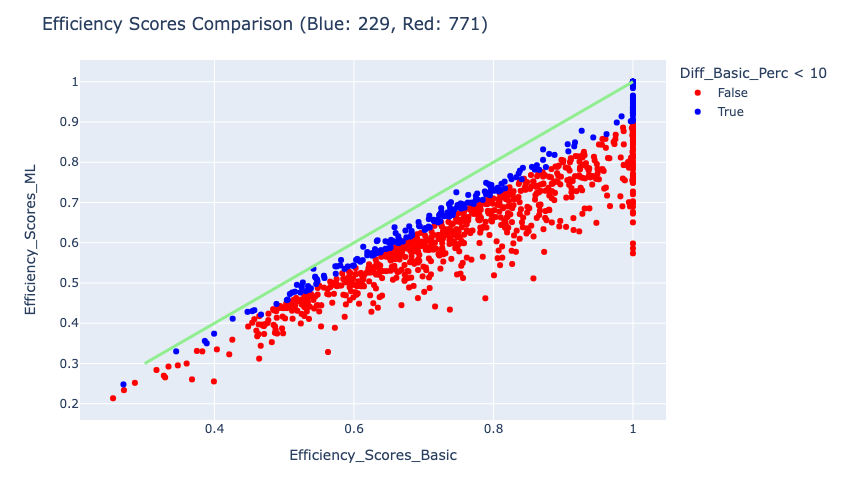

blue :  1000
red :  0


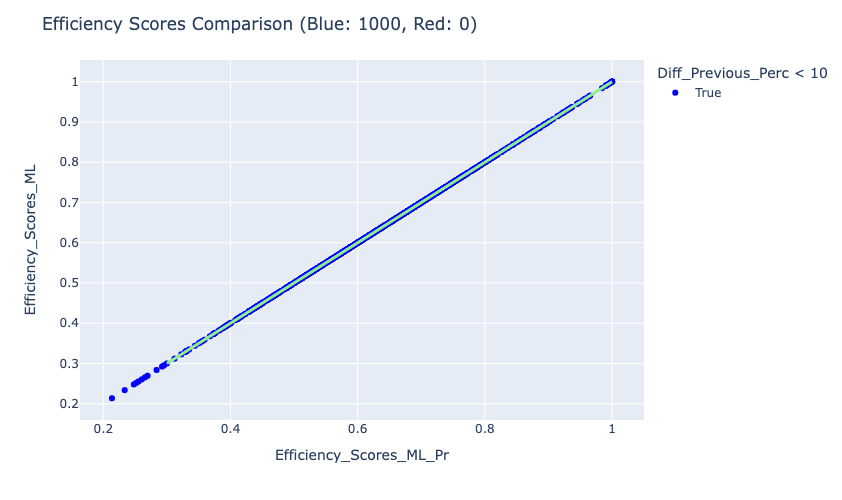

In [59]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_10.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_9.xlsx")

In [100]:
#with open('Data/Data12_1/GB_result_12I1O_1.pkl', 'wb') as f:
#    pickle.dump(results, f)

In [101]:
with open('Data/Data12_1/GB_result_12I1O_1.pkl', 'rb') as f:
    r = pickle.load(f)

In [105]:
#df_imp.to_pickle('Data/Data12_1/GB_12I1O_1_df_imp.pkl')